In [1]:
import glam
import pandas as pd
import numpy as np
import os.path
from statsmodels.stats.outliers_influence import summary_table

In [2]:
import matplotlib.pyplot as plt

from scipy.stats import invgauss
import seaborn as sns
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
from scipy import stats
from scipy.stats.stats import pearsonr # Pearson's correlation
import statsmodels.api as sm

#import warnings
#warnings.filterwarnings('ignore')

In [3]:
np.random.seed(23) # from random.org

In [4]:
# For rpy2

import rpy2

%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice

# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


In [5]:
# For MacMini proper running
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
def correl_plot(data_all,x_variable, x_varlabel,y_variable,y_varlabel):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_all, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_all[x_variable]
    y=data_all[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title(title)    
    results = pearsonr(data_all[x_variable], data_all[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    plt.show()

In [7]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [8]:
def splitBy(data_exp1, Splits_headers = ['ConfSplit', 'GSFMedSplit','DDTMedSplit'],Splits_variables = ['Conf', 'tGSF','tDDT']):
    
    median_matrix=[]
    median_matrix_aux=[]
    median_matrix_aux_cond=[]
    Split_cols = []
    
    for h in range(len(Splits_variables)):
        median_matrix=[]
        for i in unique(data_exp1["Part"]):
            median_matrix_aux=[]
    
            for j in unique(data_exp1["BlockCond"]):
                #median_matrix_aux_cond=[]
    
                #Extract data by participant and BlockCond (1: Like, 2: Dislike)
                Splitdata = data_exp1.loc[data_exp1['Part'] == i]
                Splitdata = Splitdata.loc[Splitdata['BlockCond'] == j]
                
                # Select the column to split
                Splitdata = Splitdata.loc[:,['TrialN',Splits_variables[h]]]
                SplitSort = Splitdata.values
                # Sort for confidence column
                SplitSort = SplitSort[np.argsort(SplitSort[:, 1])]
                #print(SplitSort)
                lenPart = len(Splitdata)
                #print(lenPart)
                # Generate column with median order
                median_low = [0] * int (lenPart/2)
    
                if len(SplitSort) != 2*len(median_low):
                    median_high=  [1] * int(len(SplitSort)-len(median_low))
                else: median_high = [1] * int (lenPart/2)
            
                median_split_order = median_low + median_high
                #Attach split median order column (1 and 0)
                median_aux= np.column_stack((SplitSort,median_split_order))
                #Sort back to trial number
                SplitSorted = median_aux[np.argsort(median_aux[:, 0])]
                #print(len(SplitSorted))
                
                for kk in range(len(SplitSorted)): 
                    if len(median_matrix_aux) == 0 :
                        median_matrix_aux = SplitSorted[0]
                    else:
                        median_matrix_aux = np.vstack([median_matrix_aux, SplitSorted[kk]])
            
            
            #print(["participant "+ str(i)+ " done"])
            # sort after adding both conditions    
            median_matrix_aux = median_matrix_aux[np.argsort(median_matrix_aux[:, 0])]
            
            #Extract only the column with the median split information
            median_matrix_aux = median_matrix_aux[:,2]
            
            #append to median matrix for the participants
            for k in range(len(median_matrix_aux)):    
                median_matrix.append(median_matrix_aux [k])
        
        median_matrix = pd.DataFrame(median_matrix,columns=[Splits_headers[h]])
        #print(len (median_matrix))
        #add new column (new split variable columns) to the split matrix
        if  h == 0:
            Split_cols = median_matrix
        else:
            Split_cols = pd.concat([Split_cols,median_matrix ],axis =1)   
    
    return Split_cols

In [9]:
%%R
library(lme4)
#library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(broom)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)
library(pbkrtest)

## Custom functions

In [10]:
def balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats):
    
    mean_rts_trials = np.zeros((value_tests.shape[0])) * np.nan
    choice_trials = np.zeros((value_tests.shape[0])) * np.nan
    DEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    AbsDEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    Ev_drifts_0_trials  = []
    Ev_drifts_1_trials = []

    n_trials, n_items = value_tests.shape

    running_idx_value = 0
    #we iterate for all the combinations of trials + gaze
    for trial in range(n_trials):
        
            # intialize the drifts
            evidence_drifts_0 = []
            evidence_drifts_1 = []

            #define value and gaze values for this particular trial
            value_trial =value_tests[trial]
            gaze_trial =gaze_tests[trial]
            
            Sim_value = value_trial
            Sim_gaze = gaze_trial
            
            Delta_E = np.zeros(n_repeats) * np.nan            
            AbsDelta_E = np.zeros(n_repeats) * np.nan
            rts = np.zeros(n_repeats) * np.nan
            choices = np.zeros(n_repeats) * np.nan
            trial_idx = np.zeros(n_repeats) * np.nan
            repeat_idx = np.zeros(n_repeats) * np.nan
            running_idx = 0
        
            for repeat in range(n_repeats):
                    

                    
                    Evi_0, Evi_1, choice, rt = glam.driftSim.simulate_trial_drift(parameters, value_trial, gaze_trial,
                                                boundary=boundary,
                                                error_weight=error_weight,
                                                error_range=error_range)
                    
                    Delta_E[running_idx] = Evi_1[-1] - Evi_0[-1]
                    AbsDelta_E[running_idx] = abs(Evi_0[-1] - Evi_1[-1])                        
                    rts[running_idx] = rt
                    choices[running_idx] = choice
                    trial_idx[running_idx] = trial
                    repeat_idx[running_idx] = repeat
                    # Add a new sequence of drift for this particular trial
                    evidence_drifts_0.append(Evi_0)
                    evidence_drifts_1.append(Evi_1)
                    
                    running_idx += 1
                    
               
            # Add the mean value for this parameters interation               
            mean_rts_trials [running_idx_value] = rts.mean()
            choice_trials [running_idx_value]= choices.mean() 
            DEv_trials [running_idx_value] = Delta_E.mean()
            AbsDEv_trials [running_idx_value]= AbsDelta_E.mean()
            Ev_drifts_0_trials.append(evidence_drifts_0)
            Ev_drifts_1_trials.append(evidence_drifts_1)
 
            running_idx_value += 1 

    return AbsDEv_trials,mean_rts_trials,Ev_drifts_0_trials,Ev_drifts_1_trials,choice_trials

In [11]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

    
        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [12]:
def correl_plot(data_all,x_variable, x_varlabel,y_variable,y_varlabel):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_all, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_all[x_variable]
    y=data_all[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title(title)    
    results = pearsonr(data_all[x_variable], data_all[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    plt.show()

In [13]:
def add_difficulty(df):
    """
    Compute trial difficulties and add to DataFrame.

    Maximum value -  other values.
    In the binary case, this reduces to abs(v0 - v1).

    Parameters
    ----------
    df :      <pandas DataFrame>
              Trial wise DataFrame containing columns for item_value_i
    """

    values = df[['LVal','RVal']].values
    values_sorted = np.sort(values, axis=1)
    difficulty = values_sorted[:, -1] - np.mean(values_sorted[:, :-1], axis=1)

    levels =  (np.max(difficulty) - np.min(difficulty))/10

    lev_label = np.arange(np.min(difficulty), np.max(difficulty) + levels,levels) 
    
    difficulty2= []
    for i in range(len(difficulty)):
         difficulty2.append( lev_label[ int(difficulty[i]//levels)] )
     
    difficulty = difficulty2
    
    df['difficulty'] = np.around(difficulty, decimals = 0)
    df['difficulty'] = difficulty
    
    return df.copy()

In [14]:
def plot_DEv_Conf(data, ax=None, xlims=(0, 25), xlabel_skip=2,color1 = '#4F6A9A'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 15))
        # Set seaborn style for the plot
        sns.set(style='white')

    df = data.copy()

    # Compute relevant variables
    df = add_difficulty(df)
    
    
    # select data to use
    
    data_labels = ['zConf_human','zAbsDEv']
    
    for i in range(len(data_labels)):
        # Compute summary statistics
        subject_means = df.groupby(['Part', 'difficulty'])[data_labels[i]].mean()
        means = subject_means.groupby('difficulty').mean()[xlims[0]:xlims[1]]
        sems = subject_means.groupby('difficulty').sem()[xlims[0]:xlims[1]]
    
        x = np.arange(len(means))
        
        # Add labels for scatter plot of mean rt per participant
        scatter_data = subject_means.reset_index()
        x_scatter = []
        group_labels = np.sort(scatter_data.difficulty.unique())

        for ii in range(len(scatter_data.difficulty.values)):
            a = scatter_data.difficulty.values[ii]
            position_item =  x[np.where(group_labels==a)[0][0]]
            x_scatter.append(position_item) 
        ## ********    
        
        predicted = False if i == 0 else True
        
        # Colors for predicted
        c_pred = [color1,'#606060','#607681' ]
        
        if not predicted:  # plot underlying data
            ax.plot(x, means, 'o', markerfacecolor=color1, markersize = 10, fillstyle = 'full',
                    color=color1, linewidth=1)
            ax.vlines(x, means - sems, means + sems,
                      linewidth=1, color= color1)
            jittr = np.random.uniform(low=-max(x)/20,high=max(x)/20,size=len(scatter_data))/2
            ax.plot(x_scatter+jittr, scatter_data[data_labels[i]].values, marker='o', ms=5, color=color1,alpha=0.3,linestyle="None")
    
        else:  # plot predictions
            ax.plot(x, means, '--o', markerfacecolor=c_pred[i],color=c_pred[i], linewidth=2.5, markersize = 10)

    #ax.set_ylim(2000, 3500)
    font_size_this = 22
    ax.set_xlabel('|ΔVal|',fontsize=font_size_this)
    #ax.set_ylabel( r'zΔ$\epsilon$ / zConfidence',fontsize=font_size_this)
    ax.set_ylabel( r'zΔe / zConfidence',fontsize=font_size_this)
    ax.set_xticks(x[::xlabel_skip])
    ax.tick_params(axis = 'y',labelsize=font_size_this)
    ax.tick_params(axis = 'x',labelsize=font_size_this)

    ax.set_xticklabels(np.around(means.index.values[::xlabel_skip],decimals = 1))
    sns.despine()



In [15]:
def add_difficulty_TotVal(df,TotVal_label):
    """
    Compute trial difficulties and add to DataFrame.

    Maximum value -  other values.
    In the binary case, this reduces to abs(v0 - v1).

    Parameters
    ----------
    df :      <pandas DataFrame>
              Trial wise DataFrame containing columns for item_value_i
    """

    difficulty = df[[TotVal_label]].values

    levels =  (np.max(difficulty) - np.min(difficulty))/10

    lev_label = np.arange(np.min(difficulty), np.max(difficulty) + levels,levels) 
    min_difficulty = np.min(difficulty)
    
    difficulty2= []
    for i in range(len(difficulty)):
         difficulty2.append( lev_label[ int((difficulty[i]-min_difficulty)//levels)] )
     
    difficulty = difficulty2
    
    df['difficulty'] = np.around(difficulty, decimals = 0)
    df['difficulty'] = difficulty
    
    return df.copy()

In [67]:
def plot_DEv_Conf_TotVal(data, TotVal_label, ax=None, xlims=(0, 250), xlabel_skip=2,color1 = '#4F6A9A'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 15))
        # Set seaborn style for the plot
        sns.set(style='white')

    df = data.copy()

    # Compute relevant variables
    df = add_difficulty_TotVal(df,TotVal_label)
    print ('Done with TotVal')
    
    # select data to use
    
    data_labels = ['zConf_human','zAbsDEv']
    
    for i in range(len(data_labels)):
        # Compute summary statistics
        subject_means = df.groupby(['Part','difficulty'])[data_labels[i]].mean()
        means = subject_means.groupby('difficulty').mean()[xlims[0]:xlims[1]]
        sems = subject_means.groupby('difficulty').sem()[xlims[0]:xlims[1]]
    
        x = np.arange(len(means))
        
        # Add labels for scatter plot of mean rt per participant
        scatter_data = subject_means.reset_index()
        x_scatter = []
        group_labels = np.sort(scatter_data.difficulty.unique())
        for ii in range(len(scatter_data.difficulty.values)):
            a = scatter_data.difficulty.values[ii]
            position_item =  x[np.where(group_labels==a)[0][0]]
            x_scatter.append(position_item) 
        ## ********    
        
        predicted = False if i == 0 else True
        
        # Colors for predicted
        c_pred = [color1,'#606060','#607681' ]
        
        if not predicted:  # plot underlying data
            ax.plot(x, means, 'o', markerfacecolor=color1, markersize = 10, fillstyle = 'full',
                    color=color1, linewidth=1)
            ax.vlines(x, means - sems, means + sems,
                      linewidth=1, color= color1)
            jittr = np.random.uniform(low=-max(x)/20,high=max(x)/20,size=len(scatter_data))/2
            ax.plot(x_scatter+jittr, scatter_data[data_labels[i]].values, marker='o', ms=5, color=color1,alpha=0.3,linestyle="None")
    
        else:  # plot predictions
            ax.plot(x, means, '--o', markerfacecolor=c_pred[i],color=c_pred[i], linewidth=2.5, markersize = 10)
    font_size_this = 22
    #ax.set_ylim(2000, 3500)
    ax.set_xlabel('|ΣVal|',fontsize=font_size_this)
    #ax.set_ylabel( r'zΔ$\epsilon$ / zConfidence',fontsize=font_size_this)
    ax.set_ylabel( r'zΔe / zConfidence',fontsize=font_size_this)
    ax.set_xticks(x[::xlabel_skip])
    ax.tick_params(axis = 'y',labelsize=font_size_this)
    ax.tick_params(axis = 'x',labelsize=font_size_this)
    ax.set_xticklabels(np.around(means.index.values[::xlabel_skip],decimals = 1))
    sns.despine()


In [17]:
def splitBy(data_exp1, Splits_headers = ['ConfSplit', 'GSFMedSplit','DDTMedSplit'],Splits_variables = ['Conf', 'tGSF','tDDT']):
    
    median_matrix=[]
    median_matrix_aux=[]
    median_matrix_aux_cond=[]
    Split_cols = []
    
    for h in range(len(Splits_variables)):
        median_matrix=[]
        for i in data_exp1["Part"].unique():
            median_matrix_aux=[]
    
            for j in data_exp1["BlockCond"].unique():
                #median_matrix_aux_cond=[]
    
                #Extract data by participant and BlockCond (1: Like, 2: Dislike)
                Splitdata = data_exp1.loc[data_exp1['Part'] == i]
                Splitdata = Splitdata.loc[Splitdata['BlockCond'] == j]
                
                # Select the column to split
                Splitdata = Splitdata.loc[:,['TrialN',Splits_variables[h]]]
                SplitSort = Splitdata.values
                # Sort for confidence column
                SplitSort = SplitSort[np.argsort(SplitSort[:, 1])]
                #print(SplitSort)
                lenPart = len(Splitdata)
                #print(lenPart)
                # Generate column with median order
                median_low = [0] * int (lenPart/2)
    
                if len(SplitSort) != 2*len(median_low):
                    median_high=  [1] * int(len(SplitSort)-len(median_low))
                else: median_high = [1] * int (lenPart/2)
            
                median_split_order = median_low + median_high
                #Attach split median order column (1 and 0)
                median_aux= np.column_stack((SplitSort,median_split_order))
                #Sort back to trial number
                SplitSorted = median_aux[np.argsort(median_aux[:, 0])]
                #print(len(SplitSorted))
                
                for kk in range(len(SplitSorted)): 
                    if len(median_matrix_aux) == 0 :
                        median_matrix_aux = SplitSorted[0]
                    else:
                        median_matrix_aux = np.vstack([median_matrix_aux, SplitSorted[kk]])
            
            
            #print(["participant "+ str(i)+ " done"])
            # sort after adding both conditions    
            median_matrix_aux = median_matrix_aux[np.argsort(median_matrix_aux[:, 0])]
            
            #Extract only the column with the median split information
            median_matrix_aux = median_matrix_aux[:,2]
            
            #append to median matrix for the participants
            for k in range(len(median_matrix_aux)):    
                median_matrix.append(median_matrix_aux [k])
        
        median_matrix = pd.DataFrame(median_matrix,columns=[Splits_headers[h]])
        #print(len (median_matrix))
        #add new column (new split variable columns) to the split matrix
        if  h == 0:
            Split_cols = median_matrix
        else:
            Split_cols = pd.concat([Split_cols,median_matrix ],axis =1)   
    
    return Split_cols

## Define some parameters for the simulations


In [18]:
# Parameters for the simulations
boundary=1
error_weight=0.05

## Load data and GLAM structure (More & Less)
Used binned data for simulation.

In [19]:
data = pd.read_csv(str('data/PF2019_data/GlamDataPF2019_More_NoBin_33.csv'))
# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

data2 = pd.read_csv(str('data/PF2019_data/GlamDataPF2019_Less_Inv_NoBin_33.csv'))
# Subset only necessary columns
data2 = data2[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]
data2.subject.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33])

In [20]:
len(data2.subject.unique())

32

## * Since subject 32 is eliminated for this analysis we need to take out from the other dataframe

In [21]:
# Load data for PF2019 study 

# Like condition 

data_all0 = pd.read_csv('data/PF2019_data/DataPerceptualFramingNotebook_v1.csv')
data_all0 = data_all0.drop(['Unnamed: 0'], axis=1)

# Take out participant 31
data_all0 = data_all0.loc[data_all0['Part'] != 31]

data_all0=data_all0.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})

In [22]:
data_all0.Part.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33])

In [23]:
len(data_all0.Part.unique())

32

In [24]:
data_all0["zGSF"] = z_score1(data_all0,'Part',"GSF")
data_all0["zDDT"] = z_score1(data_all0,'Part',"DDT")
data_all0["AbsDDT"] = abs(data_all0["DDT"])
data_all0["zAbsDDT"] = z_score1(data_all0,'Part',"AbsDDT")

data_all0["TotVal"] = data_all0['LVal']+ data_all0['RVal']
data_all0["zTotVal"] = z_score1(data_all0,'Part',"TotVal")

data_all0["ChosenVal"] = data_all0['RVal']*data_all0['Choice']+ data_all0['LVal']*(1-data_all0['Choice'])
data_all0["UnchosenVal"] = data_all0['LVal']*data_all0['Choice']+ data_all0['RVal']*(1-data_all0['Choice'])
data_all0["zChosenVal"] = z_score1(data_all0,'Part',"ChosenVal")
data_all0["zUnchosenVal"] = z_score1(data_all0,'Part',"UnchosenVal")

# Change so everything is equal
data_all0 = data_all0.replace('NEXTLESS', 'MORE')
data_all0 = data_all0.replace('NEXTMORE', 'LESS')
data_all0['BlockCond'].unique()

# Change so everything is equal
data_all0 = data_all0.replace('MORE', 1)
data_all0 = data_all0.replace('LESS', 2)
data_all0['BlockCond'].unique()

# Add corrects
Correct = []
for i in range(len(data_all0)):
    if data_all0.BlockCond[i] == 1:
        if (data_all0.Choice[i] == 1 and (data_all0.LVal[i] < data_all0.RVal[i])) or (data_all0.Choice[i] == 0 and (data_all0.LVal[i] > data_all0.RVal[i])):
            Correct.append(1)
        else:
            Correct.append(0)
    if data_all0.BlockCond[i] == 2:
        if (data_all0.Choice[i] == 1 and (data_all0.LVal[i] > data_all0.RVal[i])) or (data_all0.Choice[i] == 0 and (data_all0.LVal[i] < data_all0.RVal[i])):
            Correct.append(1)
        else:
            Correct.append(0)

data_all0["Correct"] = Correct

# Add Splits
data_splits = splitBy(data_all0, Splits_headers = ['ConfSplit', 'GSFMedSplit','DDTMedSplit'],Splits_variables = ['Conf', 'GSF','DDT'])

data_all0['ConfSplit'] = data_splits['ConfSplit'].values
data_all0['GSFSplit'] = data_splits['GSFMedSplit'].values
data_all0['DDTSplit'] = data_splits['DDTMedSplit'].values

In [25]:
data_all = data_all0.loc[data_all0['BlockCond'] == 1]   # MORE
data_all2 = data_all0.loc[data_all0['BlockCond'] == 2] # LESS

---------------------------------------------------------
# More condition


## Load parameter estimates for participants


Use the parameter estimates from GLAM fit for Like, Binned data

In [26]:
sufix = '_individual_More_NoBin_Gamma-11_NUTS_33'
glam_full = glam.GLAM(data)
glam_full.estimates = np.load(str('results/estimates/glam_PF2019_full'+sufix+'.npy'))

# generate dataframe with new params
params_part_like = pd.DataFrame()
for i in range(len(glam_full.estimates)):    
    params_part_like1 = pd.DataFrame.from_dict(glam_full.estimates.item(i))
    params_part_like = pd.concat([params_part_like ,params_part_like1])
    
params_part_like = params_part_like.reset_index(drop=True)

params_part = params_part_like
params_part

,b,p_error,v,gamma,SNR,s,tau,t0
0,1.0,0.05,0.000041,0.85,203.91,0.009766,0.28,0.0
1,1.0,0.05,0.000012,0.89,484.37,0.005238,0.29,0.0
2,1.0,0.05,0.000031,-0.09,300.85,0.007449,0.13,0.0
3,1.0,0.05,0.000022,0.98,462.96,0.010301,0.17,0.0
4,1.0,0.05,0.000031,0.68,173.23,0.005436,0.13,0.0
5,1.0,0.05,0.000043,0.63,152.61,0.007799,0.08,0.0
6,1.0,0.05,0.000025,0.82,404.11,0.011048,0.10,0.0
7,1.0,0.05,0.000052,-0.27,123.62,0.007531,0.06,0.0
8,1.0,0.05,0.000095,0.99,54.69,0.005685,0.02,0.0
9,1.0,0.05,0.000040,0.08,185.80,0.009549,0.32,0.0


# Run drift simulations for selected values and parameters

#  1. Including gaze information in the simulation 

In [27]:
if os.path.exists(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv')):  
        data_simulation = pd.read_csv(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv'))

In [28]:
# repeats only once so we obtain one accumulator race for each difference in value given by participants DV used.
n_repeats = 1 # Repeats within the accumulator function
repeat_extra = 10 # Repeat outside the accumulator function
gaze_out = 0 # We DO want to use the gaze from the particpants

In [29]:
if not os.path.exists(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv')):  
    Part_number = []
    LVal = []
    RVal = []
    LGaze = []
    RGaze = []
    absDVal = []
    TotVal = []
    AbsDEvid = []
    RT_sim = []
    Correct_sim = []
    Choice_sim = []
    Conf_human = []
    zConf_human = []
    
    part_id = data['subject'].unique()
    
    for i in range(len(data_all['Part'].unique())):    
        for k in range(0,repeat_extra):
            PartData = data.loc[data['subject'] == part_id[i]] # dataframe including participant GLAM data
            PartDataAll = data_all.loc[data_all['Part'] == part_id[i]] # dataframe including participant all data

            value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
            
            # get confidence from participants and add to the simulations datasets
            conf_tests =PartDataAll['Conf'].values
            zconf_tests =PartDataAll['zConf'].values
            
            if gaze_out == 1:
                gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)
            else:
                gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))

            # We keep the same parameters for this case. 
            gamma = params_part['gamma'] [i]
            tau = params_part['tau'][i]
            v = params_part['v'][i]
            s = params_part['s'][i]
            t0 = 0
            
            parameters = [v , gamma, s, tau, t0]
            ## error_range given by the reaction time values for an individual participant
            rt_min = glam_full.data['rt'].values.min()
            rt_max = glam_full.data['rt'].values.max()
            error_range = (rt_min, rt_max)
        
            Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

            LVal_tmp = [item[0] for item in value_tests]
            RVal_tmp = [item[1] for item in value_tests]
            
            LGaze_tmp = [item[0] for item in gaze_tests]
            RGaze_tmp = [item[1] for item in gaze_tests]
            
            
            for  j in range(len(Dev_a)):
                
                Part_number.append(i)
                Conf_human.append(conf_tests[j])
                zConf_human.append(zconf_tests[j])
                
                LVal.append(LVal_tmp[j])
                RVal.append(RVal_tmp[j])
                
                LGaze.append(LGaze_tmp[j])
                RGaze.append(RGaze_tmp[j])
                
                absDVal.append(abs(RVal_tmp[j] -  LVal_tmp[j]))
                TotVal.append(RVal_tmp[j] +  LVal_tmp[j])
                
                if (choices[j] == 1 and value_tests[j][1]>value_tests[j][0]) or (choices[j] == 0 and value_tests[j][1]<value_tests[j][0]):
                    Correct_sim.append(1)
                else:
                    Correct_sim.append(0)
                    
                AbsDEvid.append(Dev_a[j])
                RT_sim.append(rts[j])
                Choice_sim.append(choices[j])

        print ("subj " + str(i))
        
    data_simulation =  pd.DataFrame()
    data_simulation["Part"] = Part_number
    data_simulation["LVal"] = LVal
    data_simulation["RVal"] = RVal
    data_simulation["LGaze"] = LGaze
    data_simulation["RGaze"] = RGaze
    data_simulation["AbsDVal"] = absDVal
    data_simulation["TotVal"] = TotVal
    data_simulation["AbsDEv"] = AbsDEvid
    data_simulation["RTsim"] = RT_sim
    data_simulation["Correct_sim"] = Correct_sim
    data_simulation["Choice_sim"] = Choice_sim
    data_simulation["Conf_human"] = Conf_human
    data_simulation["zConf_human"] = zConf_human
    
    data_simulation["zLVal"] = z_score1(data_simulation,'Part',"LVal")
    data_simulation["zRVal"] = z_score1(data_simulation,'Part',"RVal")
    data_simulation["zAbsDVal"] = z_score1(data_simulation,'Part',"AbsDVal")
    data_simulation["zTotVal"] = z_score1(data_simulation,'Part',"TotVal")
    data_simulation["zAbsDEv"] = z_score1(data_simulation,'Part',"AbsDEv")
    data_simulation["zRTsim"] = z_score1(data_simulation,'Part',"RTsim")

In [30]:
if not  os.path.exists(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv')):   
        data_simulation.to_csv(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv'))

In [31]:
data_simulation

,Unnamed: 0,Part,LVal,RVal,LGaze,RGaze,AbsDVal,TotVal,AbsDEv,RTsim,Correct_sim,Choice_sim,Conf_human,zConf_human,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim
0,0,1,110,131,0.669090,0.330910,21,241,0.940354,6373.0,1,1.0,44,-0.238387,1.170501,1.989851,2.095291,1.615547,0.044060,-0.598728
1,1,1,47,50,0.759630,0.240370,3,97,0.549404,7038.0,1,1.0,54,0.386207,-1.287551,-1.170501,-1.047645,-1.256537,-0.841682,-0.451678
2,2,1,50,44,0.549371,0.450629,6,94,0.946856,5298.0,1,0.0,64,1.010801,-1.170501,-1.404601,-0.523823,-1.316372,0.058790,-0.836441
3,3,1,57,50,0.608409,0.391591,7,107,1.398788,8126.0,1,0.0,44,-0.238387,-0.897384,-1.170501,-0.349215,-1.057086,1.082694,-0.211091
4,4,1,42,50,0.522849,0.477151,8,92,1.030933,10376.0,1,1.0,54,0.386207,-1.482634,-1.170501,-0.174608,-1.356262,0.249278,0.286447
5,5,1,108,110,0.559774,0.440226,2,218,0.361954,9967.0,1,1.0,44,-0.238387,1.092467,1.170501,-1.222253,1.156812,-1.266373,0.196006
6,6,1,78,80,0.682034,0.317966,2,158,1.071265,11206.0,0,0.0,54,0.386207,-0.078033,0.000000,-1.222253,-0.039890,0.340653,0.469983
7,7,1,110,92,0.565221,0.434779,18,202,1.278604,5928.0,1,0.0,44,-0.238387,1.170501,0.468200,1.571468,0.837691,0.810405,-0.697130
8,8,1,50,48,0.508019,0.491981,2,98,1.256912,7620.0,1,0.0,54,0.386207,-1.170501,-1.248534,-1.222253,-1.236592,0.761258,-0.322982
9,9,1,110,101,0.558373,0.441627,9,211,0.913235,7655.0,1,0.0,34,-0.862980,1.170501,0.819350,0.000000,1.017196,-0.017380,-0.315242


LinAlgError: SVD did not converge in Linear Least Squares

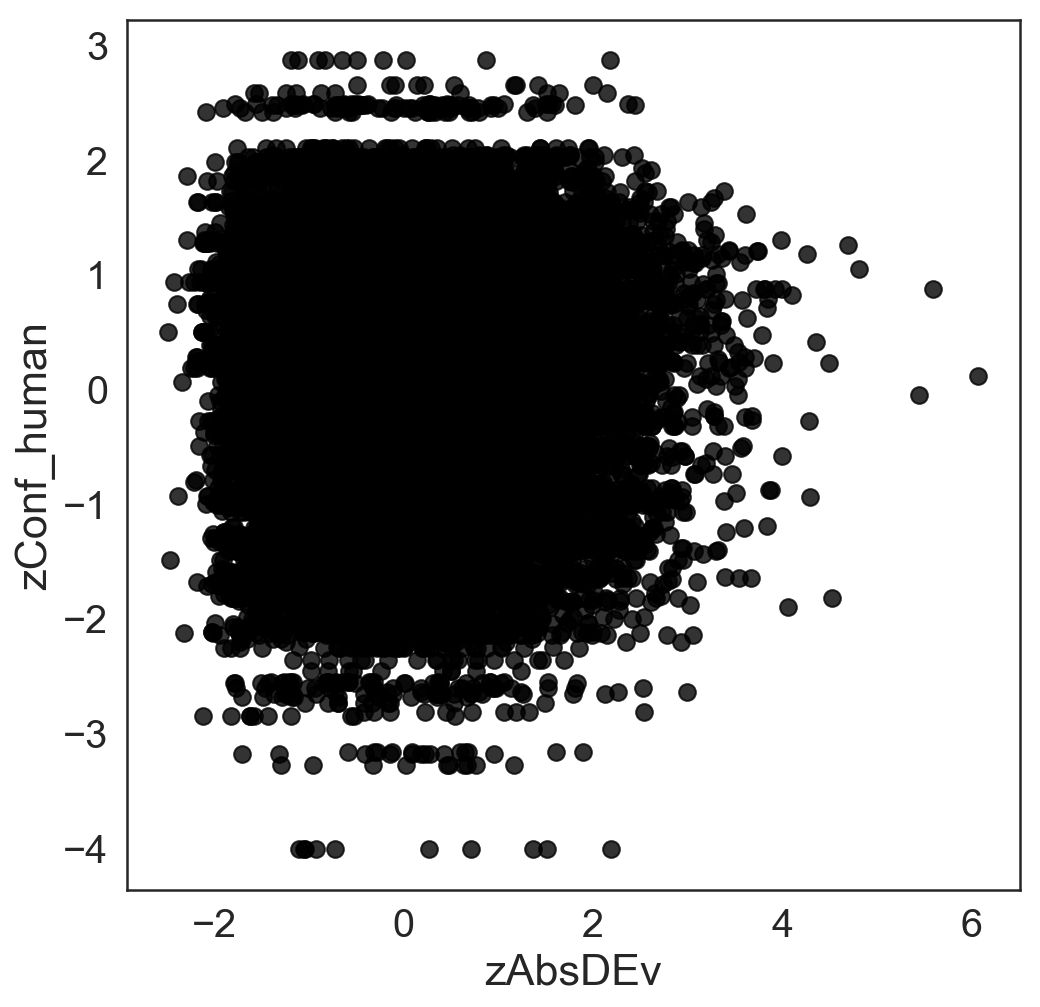

In [32]:
#correl_plot(data_simulation,'AbsDEv', "AbsDEv",'Conf_human','Conf_human')
correl_plot(data_simulation,'zAbsDEv', "zAbsDEv",'zConf_human','zConf_human')

In [ ]:
%%R -i data_simulation
d <- data_simulation

In [ ]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal + zRTsim  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

# We calculate the original regression with human data

In [33]:
%%R -i data_all
d <- data_all

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


BIC: 10052.9
Call:  glm(formula = zConf ~ zAbsDVal + zTotVal + zRT, data = d)

Coefficients:
(Intercept)     zAbsDVal      zTotVal          zRT  
    0.11649      0.09142      0.03546     -0.31379  

Degrees of Freedom: 3839 Total (i.e. Null);  3836 Residual
Null Deviance:	    3511 
Residual Deviance: 3049 	AIC: 10020


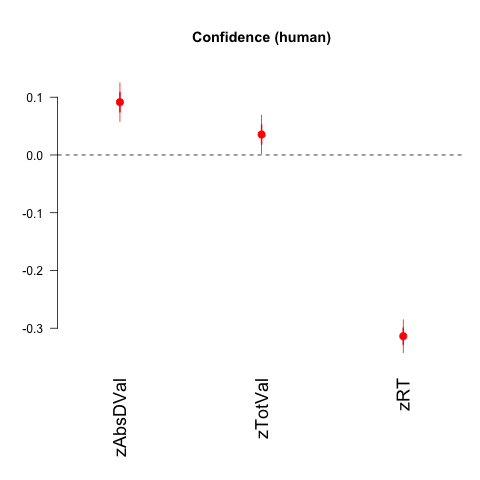

In [34]:
%%R    
title_plot = "Confidence (human)"
ModelChoice_1 <- glm(zConf ~ zAbsDVal + zTotVal + zRT  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

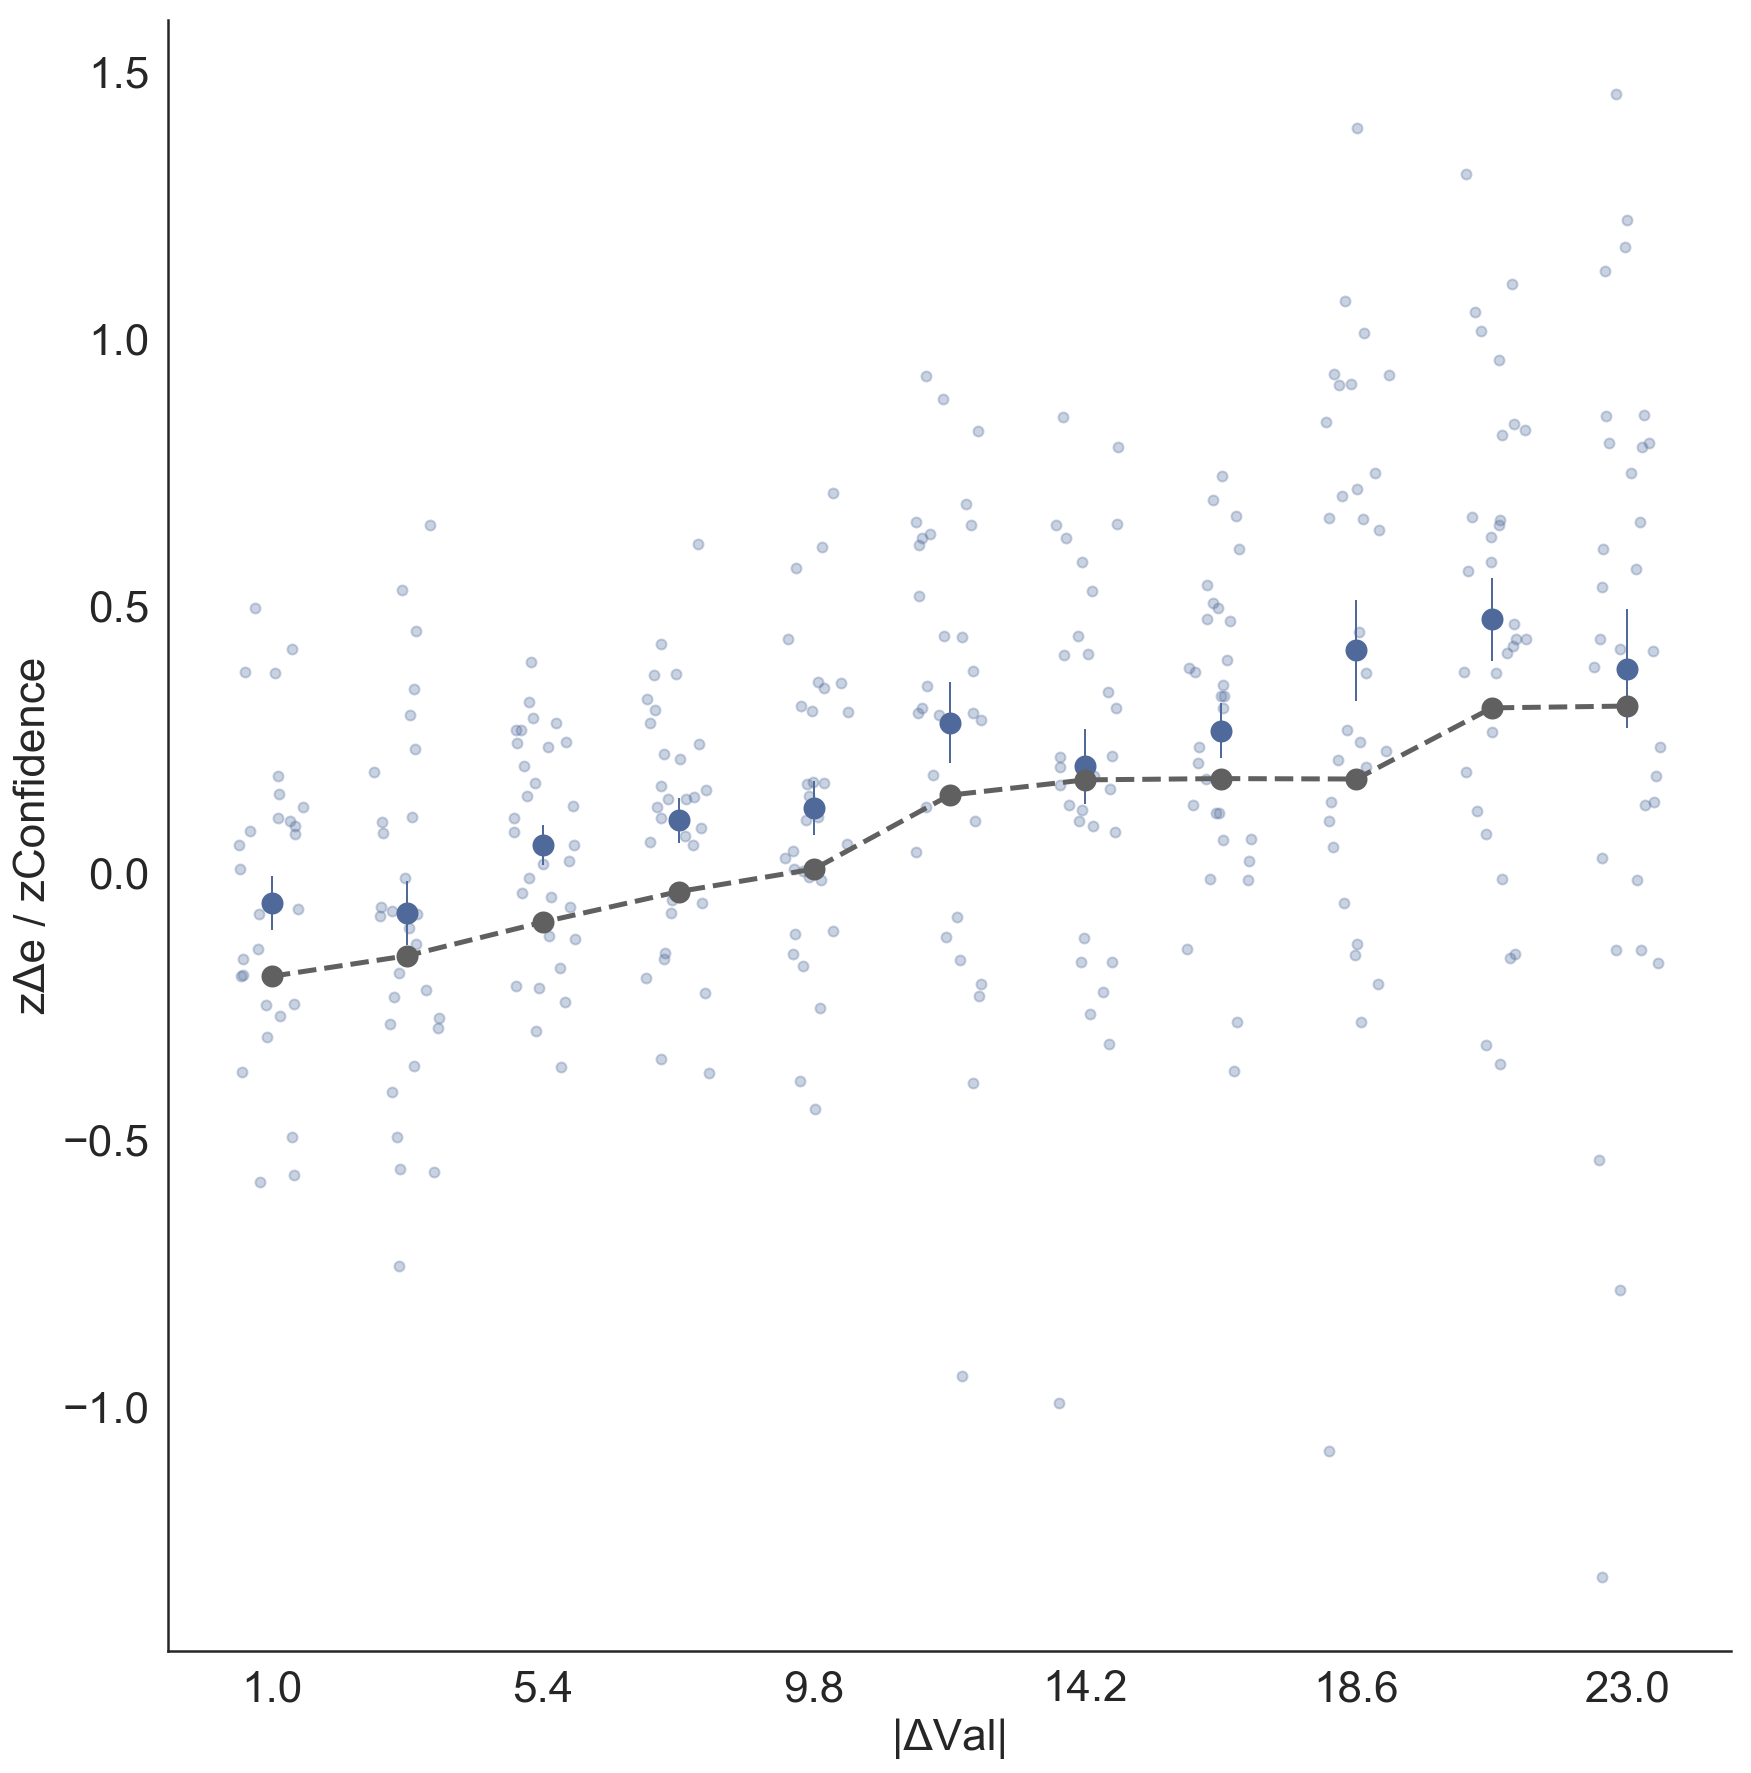

In [35]:
plot_DEv_Conf(data_simulation, xlabel_skip=2,xlims=(0, 25), color1 = '#4F6A9A')

Done with TotVal


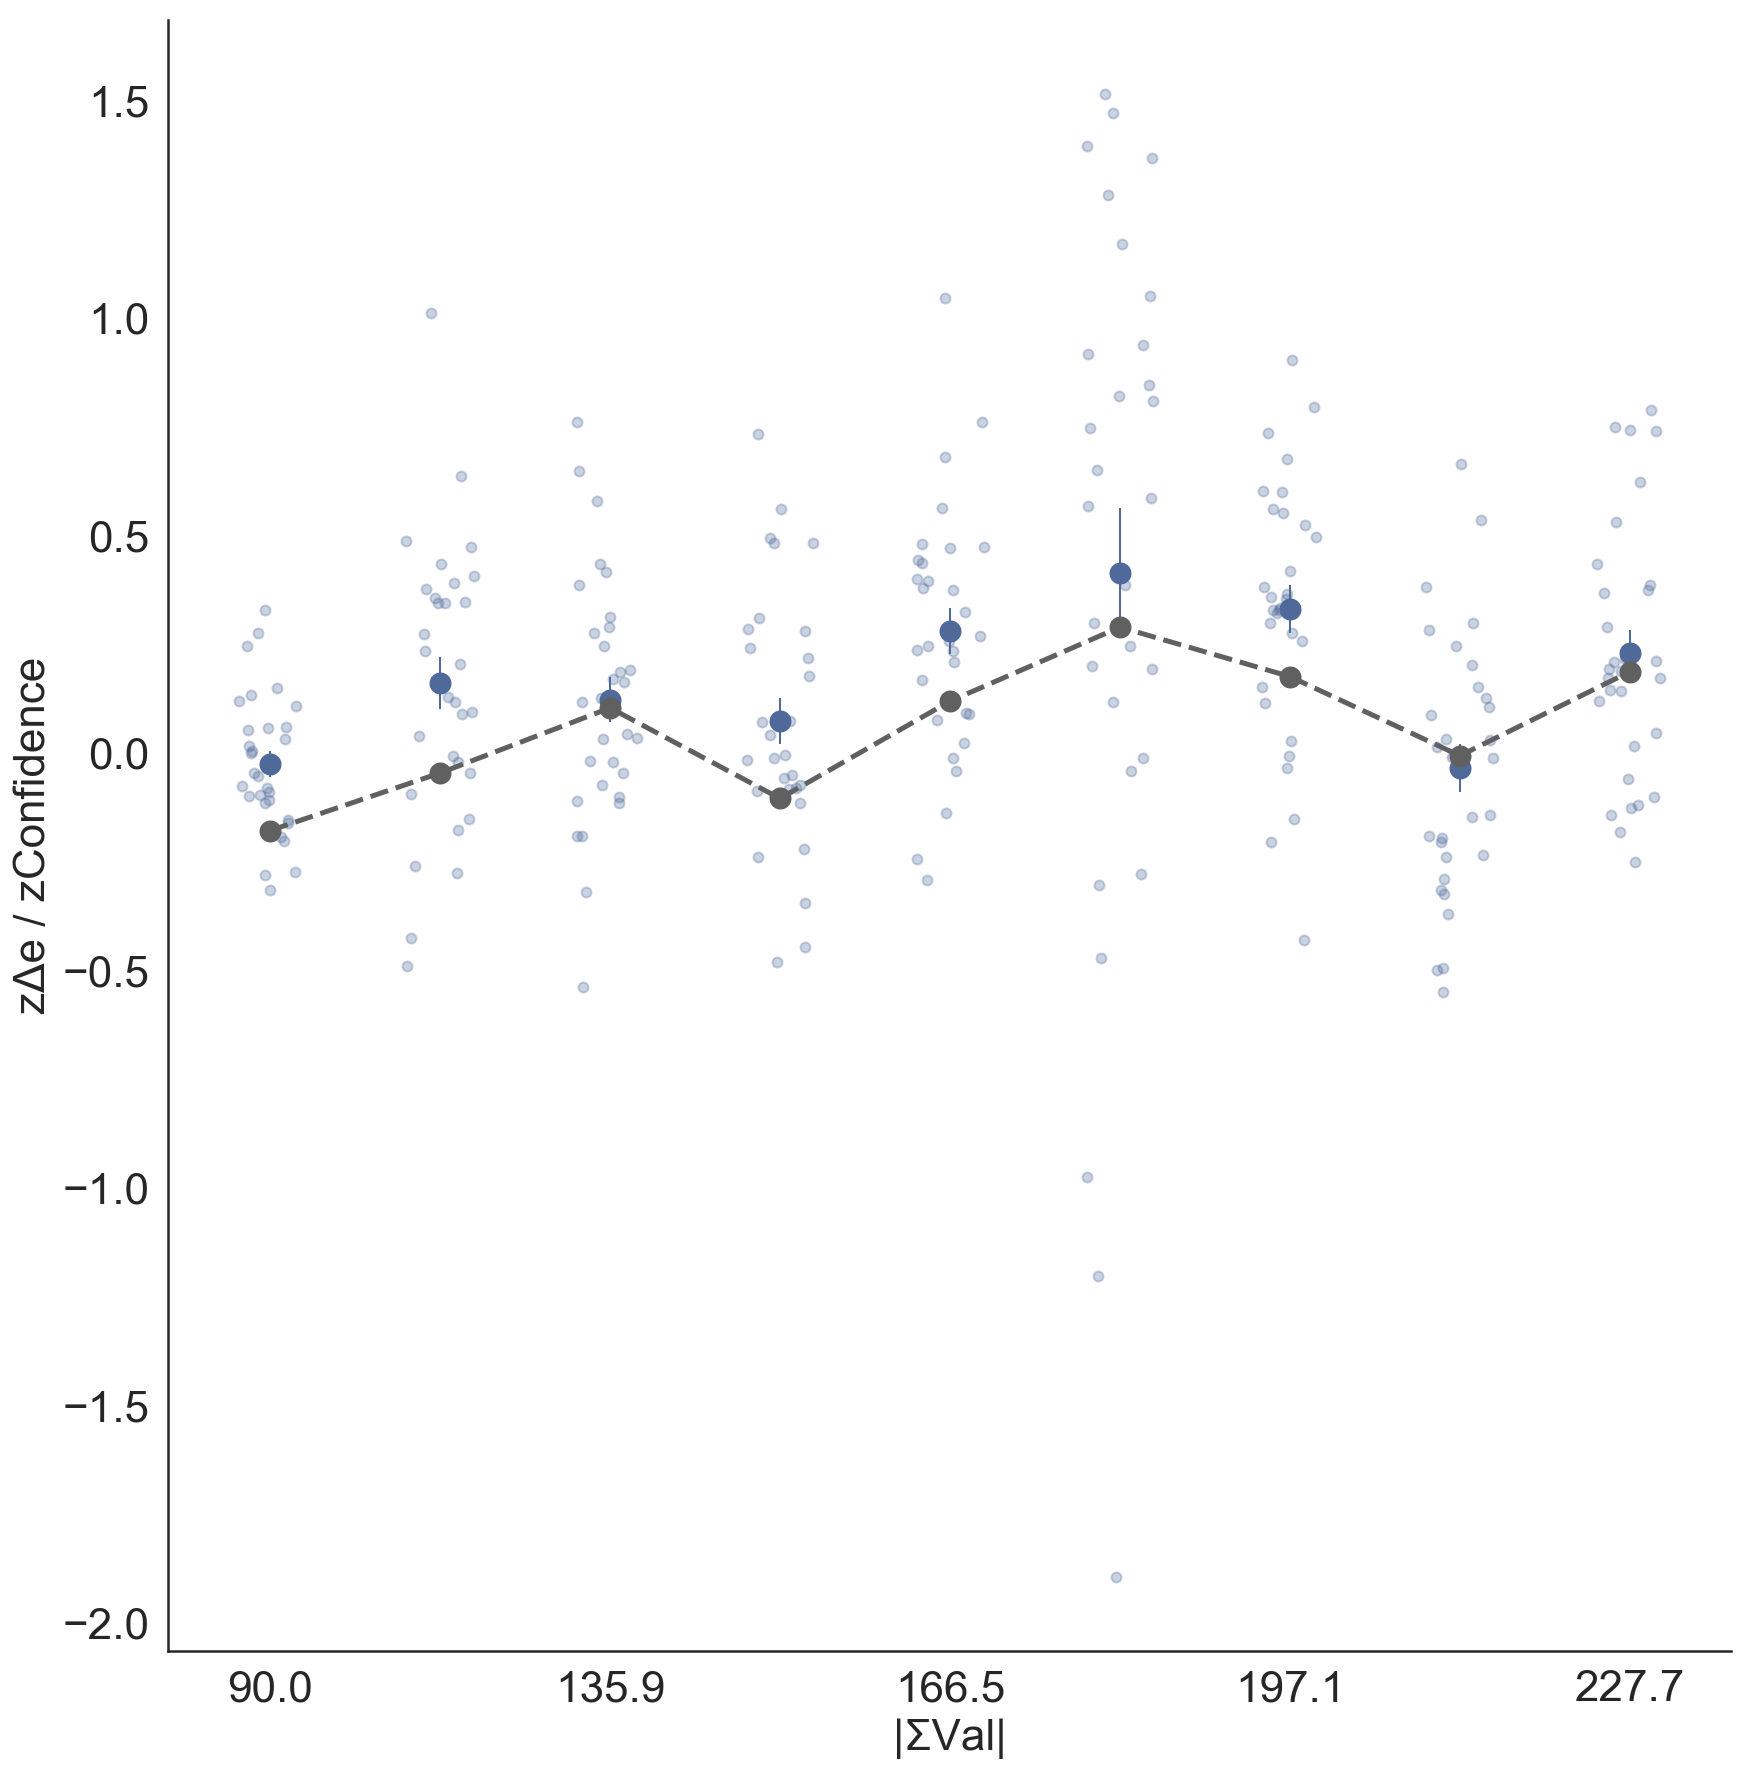

In [36]:
# xlims variable controls the range of the variable we will use to plot, if shorter than the appropiate for the input data it will crash
plot_DEv_Conf_TotVal(data_simulation,'TotVal', xlabel_skip=2,xlims=(0, 250),color1 = '#4F6A9A')

#  2. Excluding gaze information in the simulation 

In [37]:
if os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze'+sufix+'.csv')):  
        data_simulation2 = pd.read_csv(str('results/simulations_evidence/DEvidence_simulations_NoGaze'+sufix+'.csv'))

In [38]:
# repeats only once so we obtain one accumulator race for each difference in value given by participants DV used.
n_repeats = 1 # Repeats within the accumulator function
repeat_extra = 10 # Repeat outside the accumulator function
gaze_out = 1 # We DON'T want to use the gaze from the particpants

In [39]:
if not os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze'+sufix+'.csv')):  
    Part_number = []
    LVal = []
    RVal = []
    LGaze = []
    RGaze = []
    absDVal = []
    TotVal = []
    AbsDEvid = []
    RT_sim = []
    Correct_sim = []
    Choice_sim = []
    Conf_human = []
    zConf_human = []
  

    part_id = data['subject'].unique()
    
    for i in range(len(data_all['Part'].unique())):    
        for k in range(0,repeat_extra):
            PartData = data.loc[data['subject'] == part_id[i]] # dataframe including participant GLAM data
            PartDataAll = data_all.loc[data_all['Part'] == part_id[i]] # dataframe including participant all data

            value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
            
            # get confidence from participants and add to the simulations datasets
            conf_tests =PartDataAll['Conf'].values
            zconf_tests =PartDataAll['zConf'].values
            
            if gaze_out == 1:
                gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)
            else:
                gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))

            # We keep the same parameters for this case. 
            gamma = params_part['gamma'] [i]
            tau = params_part['tau'][i]
            v = params_part['v'][i]
            s = params_part['s'][i]
            t0 = 0
            
            parameters = [v , gamma, s, tau, t0]
            ## error_range given by the reaction time values for an individual participant
            rt_min = glam_full.data['rt'].values.min()
            rt_max = glam_full.data['rt'].values.max()
            error_range = (rt_min, rt_max)
        
            Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

            LVal_tmp = [item[0] for item in value_tests]
            RVal_tmp = [item[1] for item in value_tests]
            
            LGaze_tmp = [item[0] for item in gaze_tests]
            RGaze_tmp = [item[1] for item in gaze_tests]
            
            for  j in range(len(Dev_a)):
                
                Part_number.append(i)
                Conf_human.append(conf_tests[j])
                zConf_human.append(zconf_tests[j])
                
                LVal.append(LVal_tmp[j])
                RVal.append(RVal_tmp[j])
                
                LGaze.append(LGaze_tmp[j])
                RGaze.append(RGaze_tmp[j])
                
                absDVal.append(abs(RVal_tmp[j] -  LVal_tmp[j]))
                TotVal.append(RVal_tmp[j] +  LVal_tmp[j])
                
                if (choices[j] == 1 and value_tests[j][1]>value_tests[j][0]) or (choices[j] == 0 and value_tests[j][1]<value_tests[j][0]):
                    Correct_sim.append(1)
                else:
                    Correct_sim.append(0)
                    
                AbsDEvid.append(Dev_a[j])
                RT_sim.append(rts[j])
                Choice_sim.append(choices[j])

        print ("subj " + str(i))

    data_simulation2 =  pd.DataFrame()
    
    data_simulation2["Part"] = Part_number
    data_simulation2["LVal"] = LVal
    data_simulation2["RVal"] = RVal
    data_simulation2["LGaze"] = LGaze
    data_simulation2["RGaze"] = RGaze
    data_simulation2["AbsDVal"] = absDVal
    data_simulation2["TotVal"] = TotVal
    data_simulation2["AbsDEv"] = AbsDEvid
    data_simulation2["RTsim"] = RT_sim
    data_simulation2["Correct_sim"] = Correct_sim
    data_simulation2["Choice_sim"] = Choice_sim
    data_simulation2["Conf_human"] = Conf_human
    data_simulation2["zConf_human"] = zConf_human
    
    data_simulation2["zLVal"] = z_score1(data_simulation2,'Part',"LVal")
    data_simulation2["zRVal"] = z_score1(data_simulation2,'Part',"RVal")
    data_simulation2["zAbsDVal"] = z_score1(data_simulation2,'Part',"AbsDVal")
    data_simulation2["zTotVal"] = z_score1(data_simulation2,'Part',"TotVal")
    data_simulation2["zAbsDEv"] = z_score1(data_simulation2,'Part',"AbsDEv")
    data_simulation2["zRTsim"] = z_score1(data_simulation2,'Part',"RTsim")

subj 0
subj 1
subj 2
subj 3
subj 4
subj 5
subj 6
subj 7
subj 8
subj 9
subj 10
subj 11
subj 12
subj 13
subj 14
subj 15
subj 16
subj 17
subj 18
subj 19
subj 20
subj 21
subj 22
subj 23
subj 24
subj 25
subj 26
subj 27
subj 28
subj 29
subj 30
subj 31


In [40]:
if not  os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze'+sufix+'.csv')):   
        data_simulation2.to_csv(str('results/simulations_evidence/DEvidence_simulations_NoGaze'+sufix+'.csv'))

In [41]:
data_simulation2

,Part,LVal,RVal,LGaze,RGaze,AbsDVal,TotVal,AbsDEv,RTsim,Correct_sim,Choice_sim,Conf_human,zConf_human,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim
0,0,110,131,0.5,0.5,21,241,2.294203,2726.0,1,1.0,74,0.388833,1.170501,1.989851,2.095291,1.615547,3.191608,-0.004775
1,0,47,50,0.5,0.5,3,97,1.229050,3084.0,1,1.0,64,-0.125610,-1.287551,-1.170501,-1.047645,-1.256537,0.793783,0.261407
2,0,50,44,0.5,0.5,6,94,0.951388,3237.0,1,0.0,64,-0.125610,-1.170501,-1.404601,-0.523823,-1.316372,0.168724,0.375167
3,0,57,50,0.5,0.5,7,107,1.283533,3319.0,1,0.0,74,0.388833,-0.897384,-1.170501,-0.349215,-1.057086,0.916434,0.436136
4,0,42,50,0.5,0.5,8,92,0.642565,3056.0,1,1.0,54,-0.640053,-1.482634,-1.170501,-0.174608,-1.356262,-0.526485,0.240589
5,0,108,110,0.5,0.5,2,218,0.971160,3826.0,1,1.0,64,-0.125610,1.092467,1.170501,-1.222253,1.156812,0.213234,0.813103
6,0,78,80,0.5,0.5,2,158,0.336119,6367.0,1,1.0,100,1.726386,-0.078033,0.000000,-1.222253,-0.039890,-1.216343,2.702400
7,0,110,92,0.5,0.5,18,202,1.563842,2209.0,1,0.0,74,0.388833,1.170501,0.468200,1.571468,0.837691,1.547452,-0.389177
8,0,50,48,0.5,0.5,2,98,0.824295,1892.0,1,0.0,94,1.417720,-1.170501,-1.248534,-1.222253,-1.236592,-0.117382,-0.624874
9,0,110,101,0.5,0.5,9,211,0.731372,4249.0,1,0.0,24,-2.183383,1.170501,0.819350,0.000000,1.017196,-0.326567,1.127614


Pearson's r = -0.022 p =  0.0


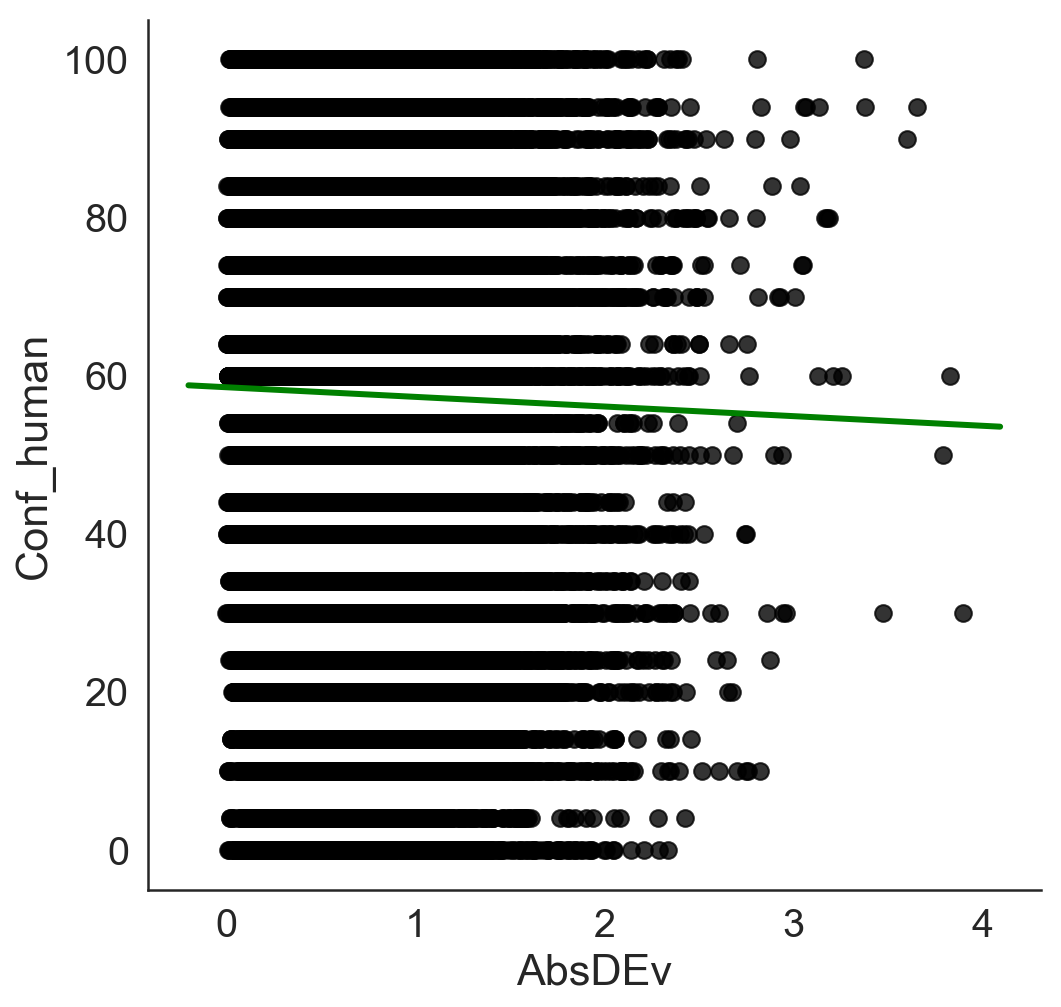

Pearson's r = 0.031 p =  0.0


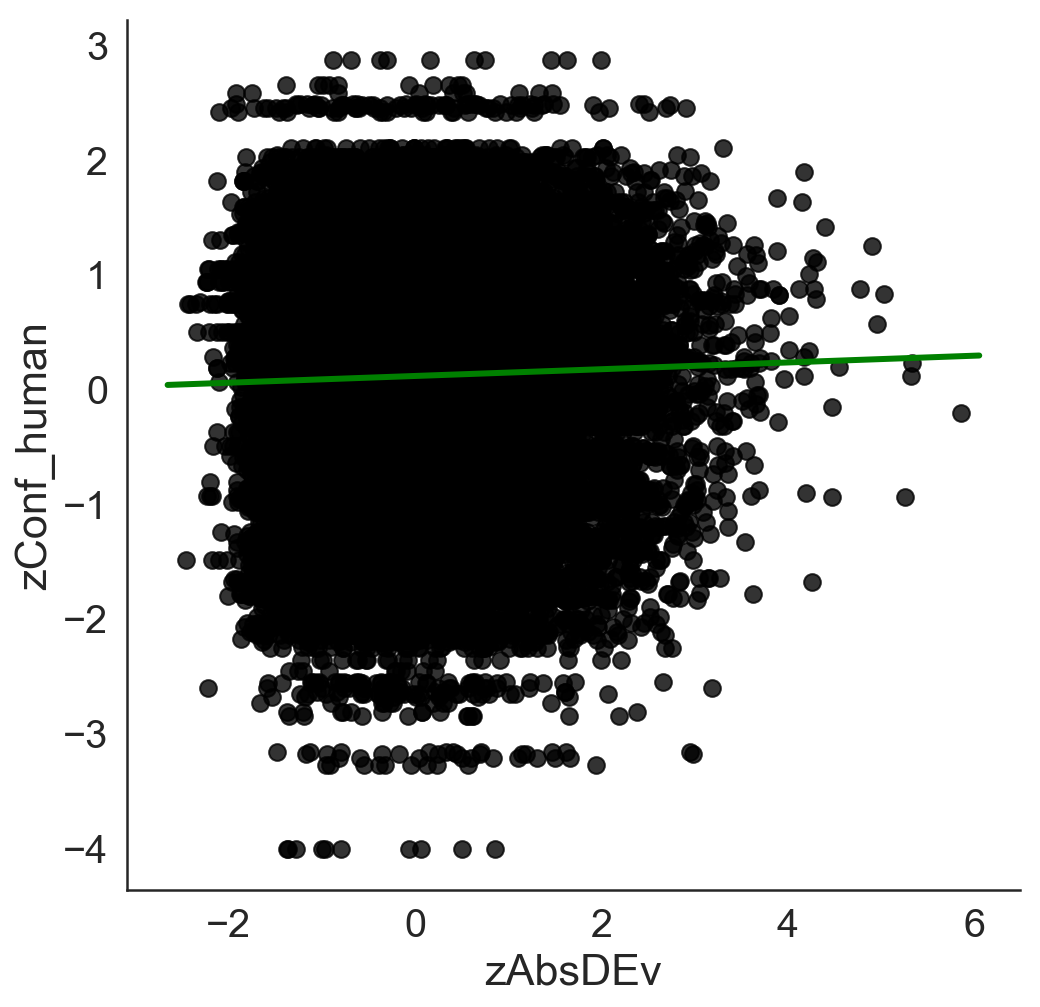

In [42]:
correl_plot(data_simulation2,'AbsDEv', "AbsDEv",'Conf_human','Conf_human')
correl_plot(data_simulation2,'zAbsDEv', "zAbsDEv",'zConf_human','zConf_human')

In [43]:
%%R -i data_simulation2
d <- data_simulation2

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


BIC: 107057.9
Call:  glm(formula = zAbsDEv ~ zAbsDVal + zTotVal + zRTsim, data = d)

Coefficients:
(Intercept)     zAbsDVal      zTotVal       zRTsim  
  2.459e-16    1.954e-01   -5.815e-03   -8.985e-02  

Degrees of Freedom: 38399 Total (i.e. Null);  38396 Residual
Null Deviance:	    38400 
Residual Deviance: 36480 	AIC: 107000


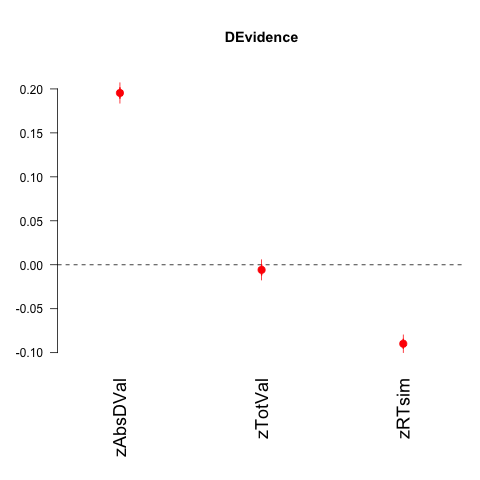

In [44]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal + zRTsim  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

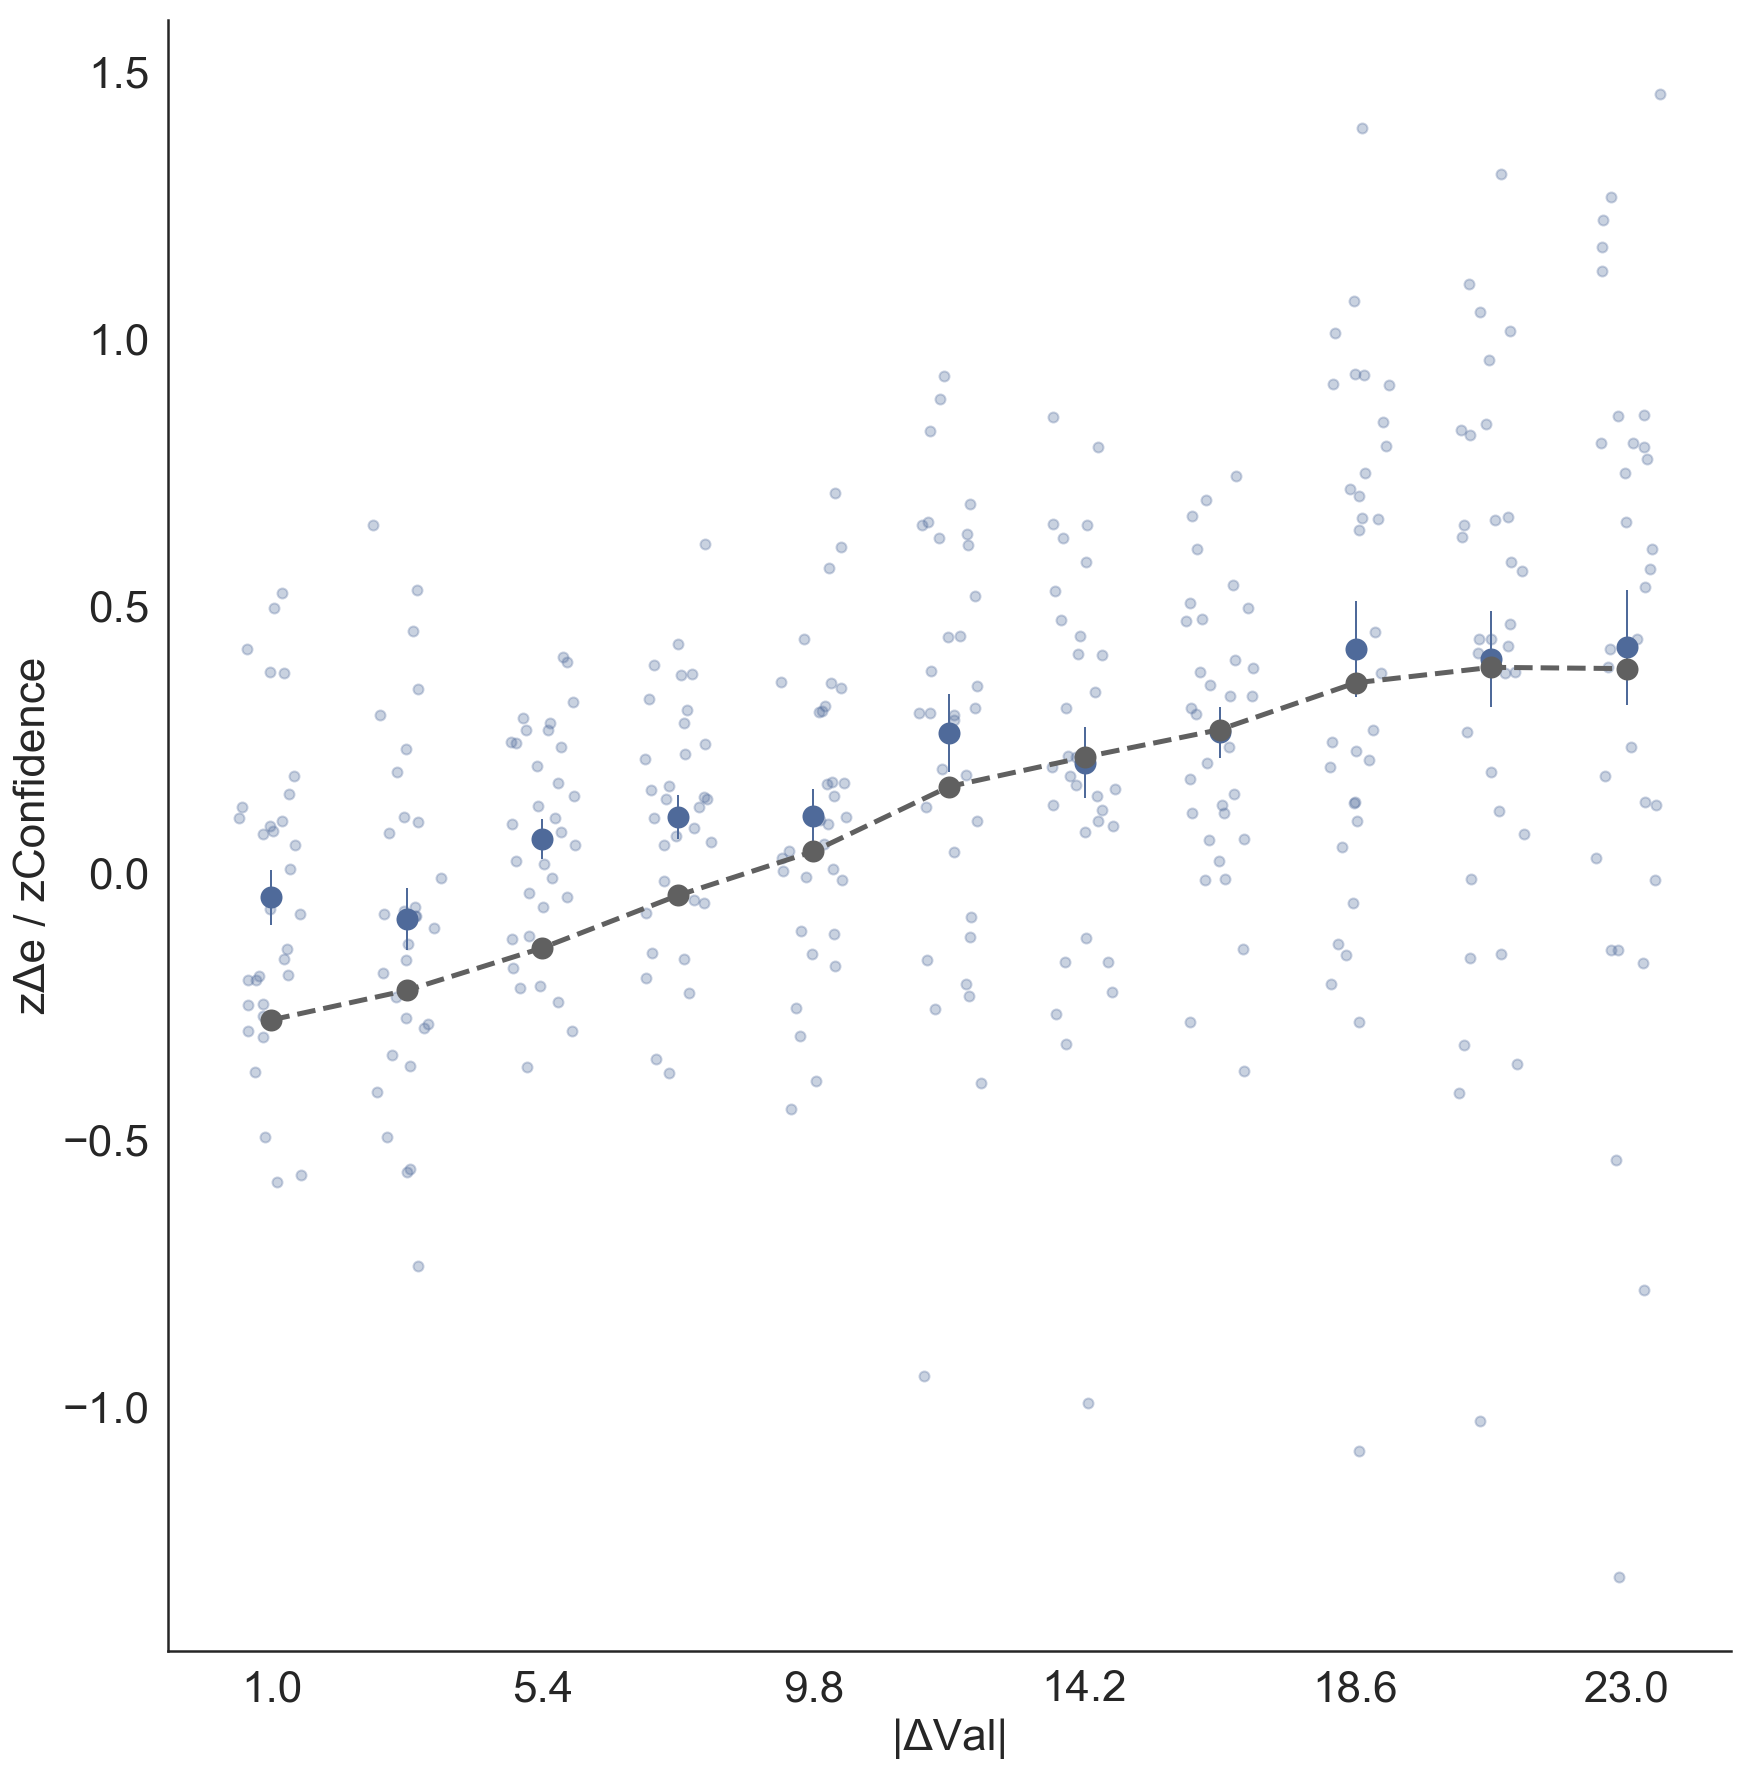

In [45]:
plot_DEv_Conf(data_simulation2, xlabel_skip=2, xlims=(0, 25), color1 = '#4F6A9A')

Done with TotVal


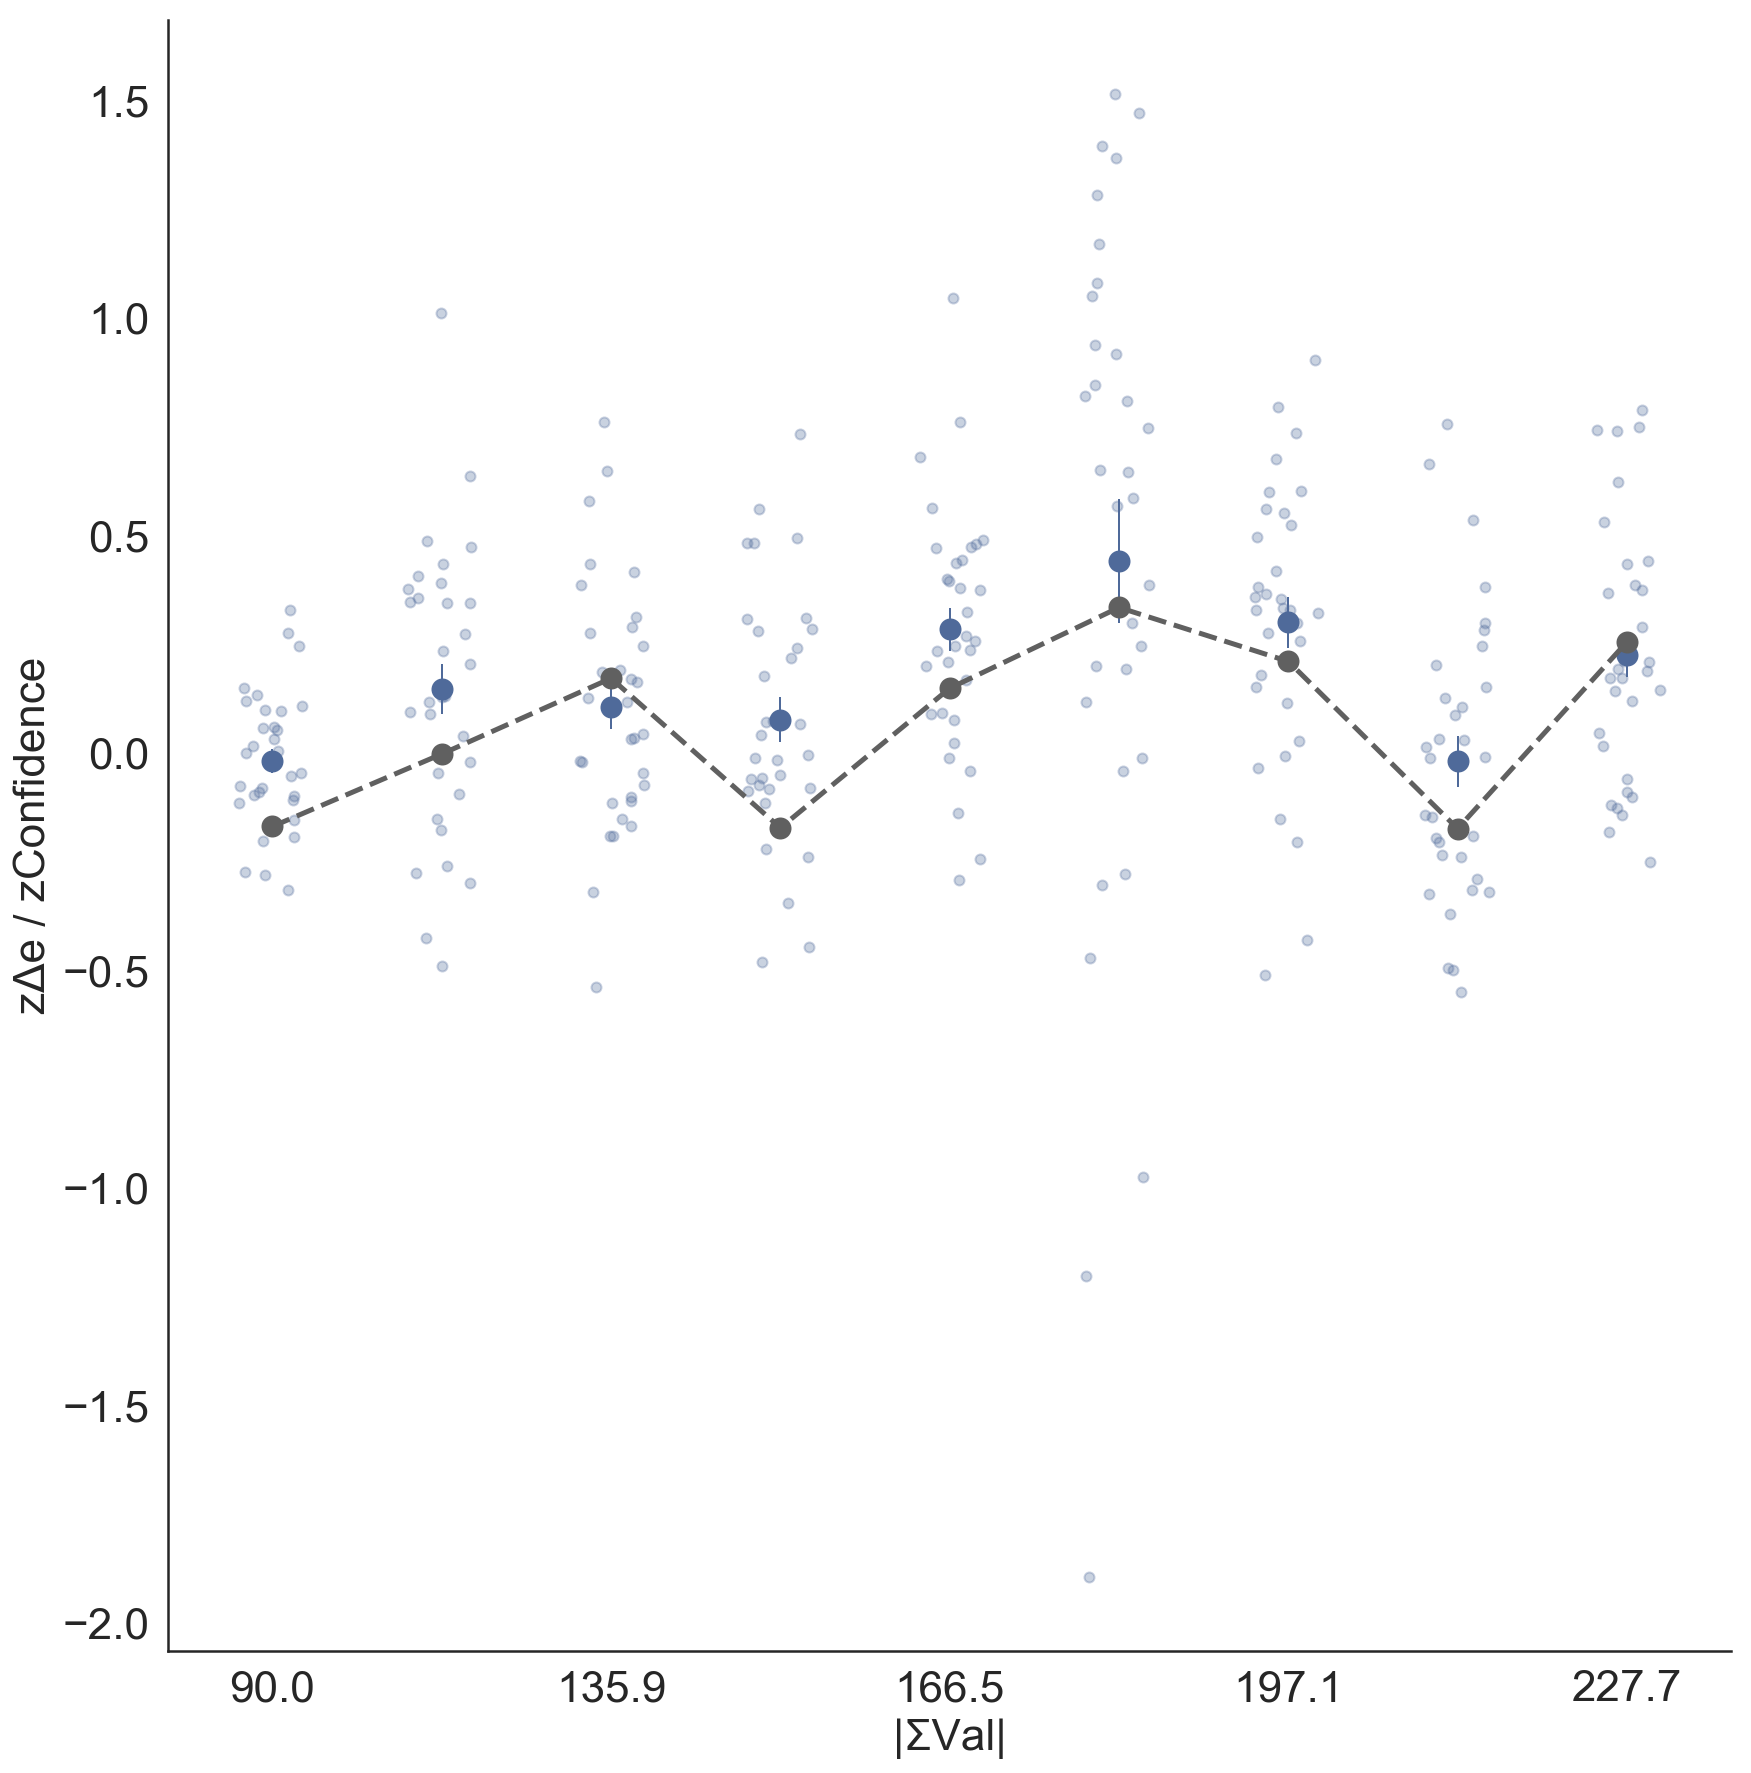

In [46]:
plot_DEv_Conf_TotVal(data_simulation2,'TotVal',xlims=(0, 250), xlabel_skip=2,color1 = '#4F6A9A')

- ---- -----------------------------------------------------------------------------------

# Less condition


## Load parameter estimates for participants


Use the parameter estimates from GLAM fit for Like, Binned data

In [51]:
sufix = '_individual_Less_Inv_NoBin_Gamma-11_NUTS_33'
glam_full = glam.GLAM(data)
glam_full.estimates = np.load(str('results/estimates/glam_PF2019_full'+sufix+'.npy'))

# generate dataframe with new params
params_part_l = pd.DataFrame()
for i in range(len(glam_full.estimates)):    
    params_part_l1 = pd.DataFrame.from_dict(glam_full.estimates.item(i))
    params_part_l = pd.concat([params_part_like ,params_part_like1])
    
params_part_l = params_part_l.reset_index(drop=True)

params_part = params_part_l
params_part

,b,p_error,v,gamma,SNR,s,tau,t0
0,1.0,0.05,0.000041,0.85,203.91,0.009766,0.28,0.0
1,1.0,0.05,0.000012,0.89,484.37,0.005238,0.29,0.0
2,1.0,0.05,0.000031,-0.09,300.85,0.007449,0.13,0.0
3,1.0,0.05,0.000022,0.98,462.96,0.010301,0.17,0.0
4,1.0,0.05,0.000031,0.68,173.23,0.005436,0.13,0.0
5,1.0,0.05,0.000043,0.63,152.61,0.007799,0.08,0.0
6,1.0,0.05,0.000025,0.82,404.11,0.011048,0.10,0.0
7,1.0,0.05,0.000052,-0.27,123.62,0.007531,0.06,0.0
8,1.0,0.05,0.000095,0.99,54.69,0.005685,0.02,0.0
9,1.0,0.05,0.000040,0.08,185.80,0.009549,0.32,0.0


# Run drift simulations for selected values and parameters

#  1. Including gaze information in the simulation 

In [52]:
if os.path.exists(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv')):  
        data_simulation = pd.read_csv(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv'))

In [53]:
# repeats only once so we obtain one accumulator race for each difference in value given by participants DV used.
n_repeats = 1 # Repeats within the accumulator function
repeat_extra = 10 # Repeat outside the accumulator function
gaze_out = 0 # We DO want to use the gaze from the particpants

In [55]:
if not os.path.exists(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv')):  
    Part_number = []
    LVal = []
    RVal = []
    LGaze = []
    RGaze = []
    absDVal = []
    TotVal = []
    AbsDEvid = []
    RT_sim = []
    Correct_sim = []
    Choice_sim = []
    Conf_human = []
    zConf_human = []

    part_id = data2['subject'].unique()
    
    for i in range(len(data_all2['Part'].unique())):    
        for k in range(0,repeat_extra):
            PartData = data2.loc[data2['subject'] == part_id[i]] # dataframe including participant GLAM data
            PartDataAll = data_all2.loc[data_all2['Part'] == part_id[i]] # dataframe including participant all data
    
            value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
            
            # get confidence from participants and add to the simulations datasets
            conf_tests =PartDataAll['Conf'].values
            zconf_tests =PartDataAll['zConf'].values
            
            if gaze_out == 1:
                gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)
            else:
                gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))

            # We keep the same parameters for this case. 
            gamma = params_part['gamma'] [i]
            tau = params_part['tau'][i]
            v = params_part['v'][i]
            s = params_part['s'][i]
            t0 = 0
            
            parameters = [v , gamma, s, tau, t0]
            ## error_range given by the reaction time values for an individual participant
            rt_min = glam_full.data['rt'].values.min()
            rt_max = glam_full.data['rt'].values.max()
            error_range = (rt_min, rt_max)
        
            Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

            LVal_tmp = [item[0] for item in value_tests]
            RVal_tmp = [item[1] for item in value_tests]
            
            LGaze_tmp = [item[0] for item in gaze_tests]
            RGaze_tmp = [item[1] for item in gaze_tests]
                
            for  j in range(len(Dev_a)):
                
                Part_number.append(i)
                Conf_human.append(conf_tests[j])
                zConf_human.append(zconf_tests[j])
                
                LVal.append(LVal_tmp[j])
                RVal.append(RVal_tmp[j])
                
                LGaze.append(LGaze_tmp[j])
                RGaze.append(RGaze_tmp[j])
            
                absDVal.append(abs(RVal_tmp[j] -  LVal_tmp[j]))
                TotVal.append(RVal_tmp[j] +  LVal_tmp[j])
                
                if (choices[j] == 1 and value_tests[j][1]>value_tests[j][0]) or (choices[j] == 0 and value_tests[j][1]<value_tests[j][0]):
                    Correct_sim.append(1)
                else:
                    Correct_sim.append(0)
                    
                AbsDEvid.append(Dev_a[j])
                RT_sim.append(rts[j])
                Choice_sim.append(choices[j])

        print ("subj " + str(i))
        
    data_simulation =  pd.DataFrame()
    data_simulation["Part"] = Part_number
    data_simulation["LVal"] = LVal
    data_simulation["RVal"] = RVal
    data_simulation["LGaze"] = LGaze
    data_simulation["RGaze"] = RGaze
    data_simulation["AbsDVal"] = absDVal
    data_simulation["TotVal"] = TotVal
    data_simulation["AbsDEv"] = AbsDEvid
    data_simulation["RTsim"] = RT_sim
    data_simulation["Correct_sim"] = Correct_sim
    data_simulation["Choice_sim"] = Choice_sim
    data_simulation["Conf_human"] = Conf_human
    data_simulation["zConf_human"] = zConf_human
    
    data_simulation["zLVal"] = z_score1(data_simulation,'Part',"LVal")
    data_simulation["zRVal"] = z_score1(data_simulation,'Part',"RVal")
    data_simulation["zAbsDVal"] = z_score1(data_simulation,'Part',"AbsDVal")
    data_simulation["zTotVal"] = z_score1(data_simulation,'Part',"TotVal")
    data_simulation["zAbsDEv"] = z_score1(data_simulation,'Part',"AbsDEv")
    data_simulation["zRTsim"] = z_score1(data_simulation,'Part',"RTsim")

subj 0
subj 1
subj 2
subj 3
subj 4
subj 5
subj 6
subj 7
subj 8
subj 9
subj 10
subj 11
subj 12
subj 13
subj 14
subj 15
subj 16
subj 17
subj 18
subj 19
subj 20
subj 21
subj 22
subj 23
subj 24
subj 25
subj 26
subj 27
subj 28
subj 29
subj 30
subj 31


In [56]:
if not  os.path.exists(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv')):   
        data_simulation.to_csv(str('results/simulations_evidence/DEvidence_simulations_'+sufix+'.csv'))

In [57]:
data_simulation

,Part,LVal,RVal,LGaze,RGaze,AbsDVal,TotVal,AbsDEv,RTsim,Correct_sim,Choice_sim,Conf_human,zConf_human,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim
0,0,63,42,0.603448,0.396552,21,105,1.302444,3221.0,1,0.0,74,0.388833,-1.170501,-1.989851,2.095291,-1.615547,0.875679,0.399538
1,0,126,123,0.490772,0.509228,3,249,0.603960,3176.0,1,0.0,54,-0.640053,1.287551,1.170501,-1.047645,1.256537,-0.674954,0.364706
2,0,123,129,0.490893,0.509107,6,252,0.361165,980.0,1,1.0,64,-0.125610,1.170501,1.404601,-0.523823,1.316372,-1.213958,-1.335101
3,0,116,123,0.639125,0.360875,7,239,0.889676,2405.0,1,1.0,84,0.903277,0.897384,1.170501,-0.349215,1.057086,-0.040664,-0.232084
4,0,131,123,0.702232,0.297768,8,254,1.170203,3085.0,1,0.0,44,-1.154496,1.482634,1.170501,-0.174608,1.356262,0.582104,0.294267
5,0,65,63,0.634756,0.365244,2,128,0.890782,2479.0,1,0.0,44,-1.154496,-1.092467,-1.170501,-1.222253,-1.156812,-0.038210,-0.174805
6,0,95,93,0.602831,0.397169,2,188,0.835967,957.0,1,0.0,74,0.388833,0.078033,0.000000,-1.222253,0.039890,-0.159899,-1.352904
7,0,63,81,0.600783,0.399217,18,144,0.721438,1173.0,1,1.0,74,0.388833,-1.170501,-0.468200,1.571468,-0.837691,-0.414152,-1.185710
8,0,123,125,0.475195,0.524805,2,248,0.037215,3607.0,1,1.0,54,-0.640053,1.170501,1.248534,-1.222253,1.236592,-1.933125,0.698320
9,0,63,72,0.436619,0.563381,9,135,0.633777,3622.0,1,1.0,34,-1.668940,-1.170501,-0.819350,0.000000,-1.017196,-0.608760,0.709931


## Since for dislike we have that TotVal represents the inverted value we take it back to the original denomination

In [81]:
data_simulation['TotVal_orig'] = np.max(data_simulation['TotVal'].unique()) - data_simulation['TotVal'] +np.min(data_simulation['TotVal'].unique())
data_simulation["zTotVal_orig"] = z_score1(data_simulation,'Part',"TotVal_orig")

Pearson's r = 0.003 p =  0.519


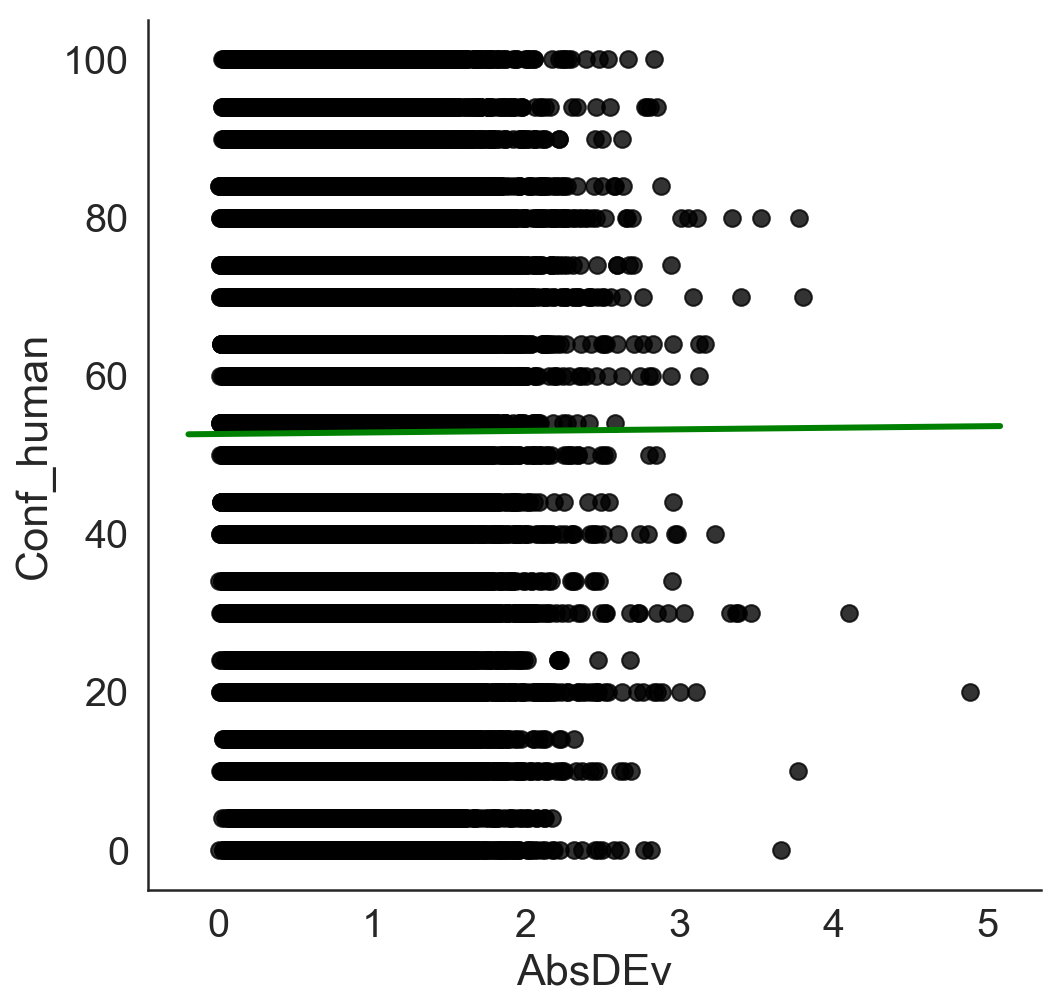

Pearson's r = 0.044 p =  0.0


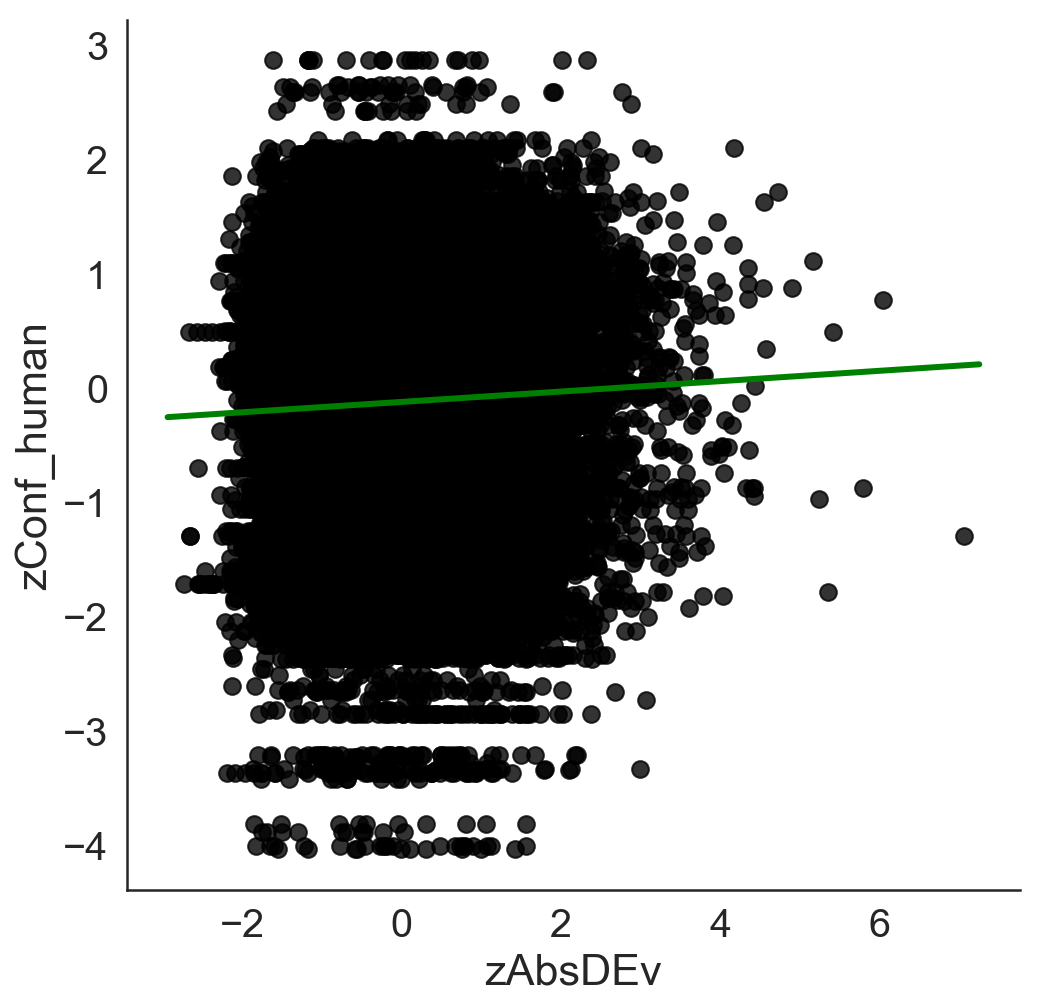

In [82]:
correl_plot(data_simulation,'AbsDEv', "AbsDEv",'Conf_human','Conf_human')
correl_plot(data_simulation,'zAbsDEv', "zAbsDEv",'zConf_human','zConf_human')

In [83]:
%%R -i data_simulation
d <- data_simulation

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


BIC: 107963.1
Call:  glm(formula = zAbsDEv ~ zAbsDVal + zTotVal_orig + zRTsim, data = d)

Coefficients:
 (Intercept)      zAbsDVal  zTotVal_orig        zRTsim  
  -2.553e-16     1.426e-01    -5.454e-02    -9.684e-02  

Degrees of Freedom: 38399 Total (i.e. Null);  38396 Residual
Null Deviance:	    38400 
Residual Deviance: 37350 	AIC: 107900


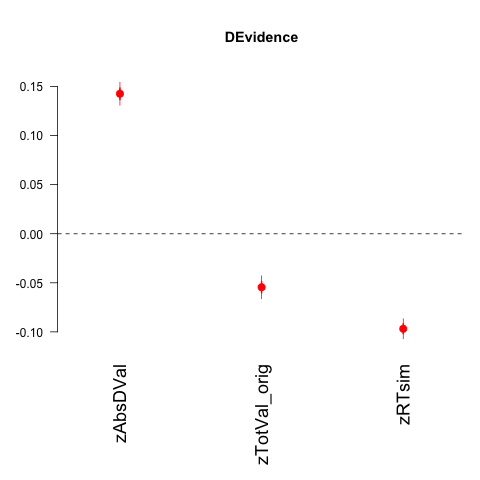

In [84]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal_orig + zRTsim  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

# We calculate the original regression with human data

In [85]:
%%R -i data_all2
d <- data_all2

BIC: 10700.06
Call:  glm(formula = zConf ~ zAbsDVal + zTotVal + zRT, data = d)

Coefficients:
(Intercept)     zAbsDVal      zTotVal          zRT  
    -0.1166       0.1579      -0.1690      -0.2893  

Degrees of Freedom: 3839 Total (i.e. Null);  3836 Residual
Null Deviance:	    4061 
Residual Deviance: 3609 	AIC: 10670


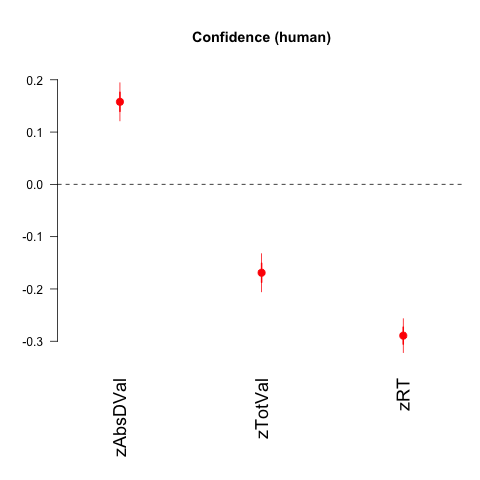

In [86]:
%%R    
title_plot = "Confidence (human)"
ModelChoice_1 <- glm(zConf ~ zAbsDVal + zTotVal + zRT  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

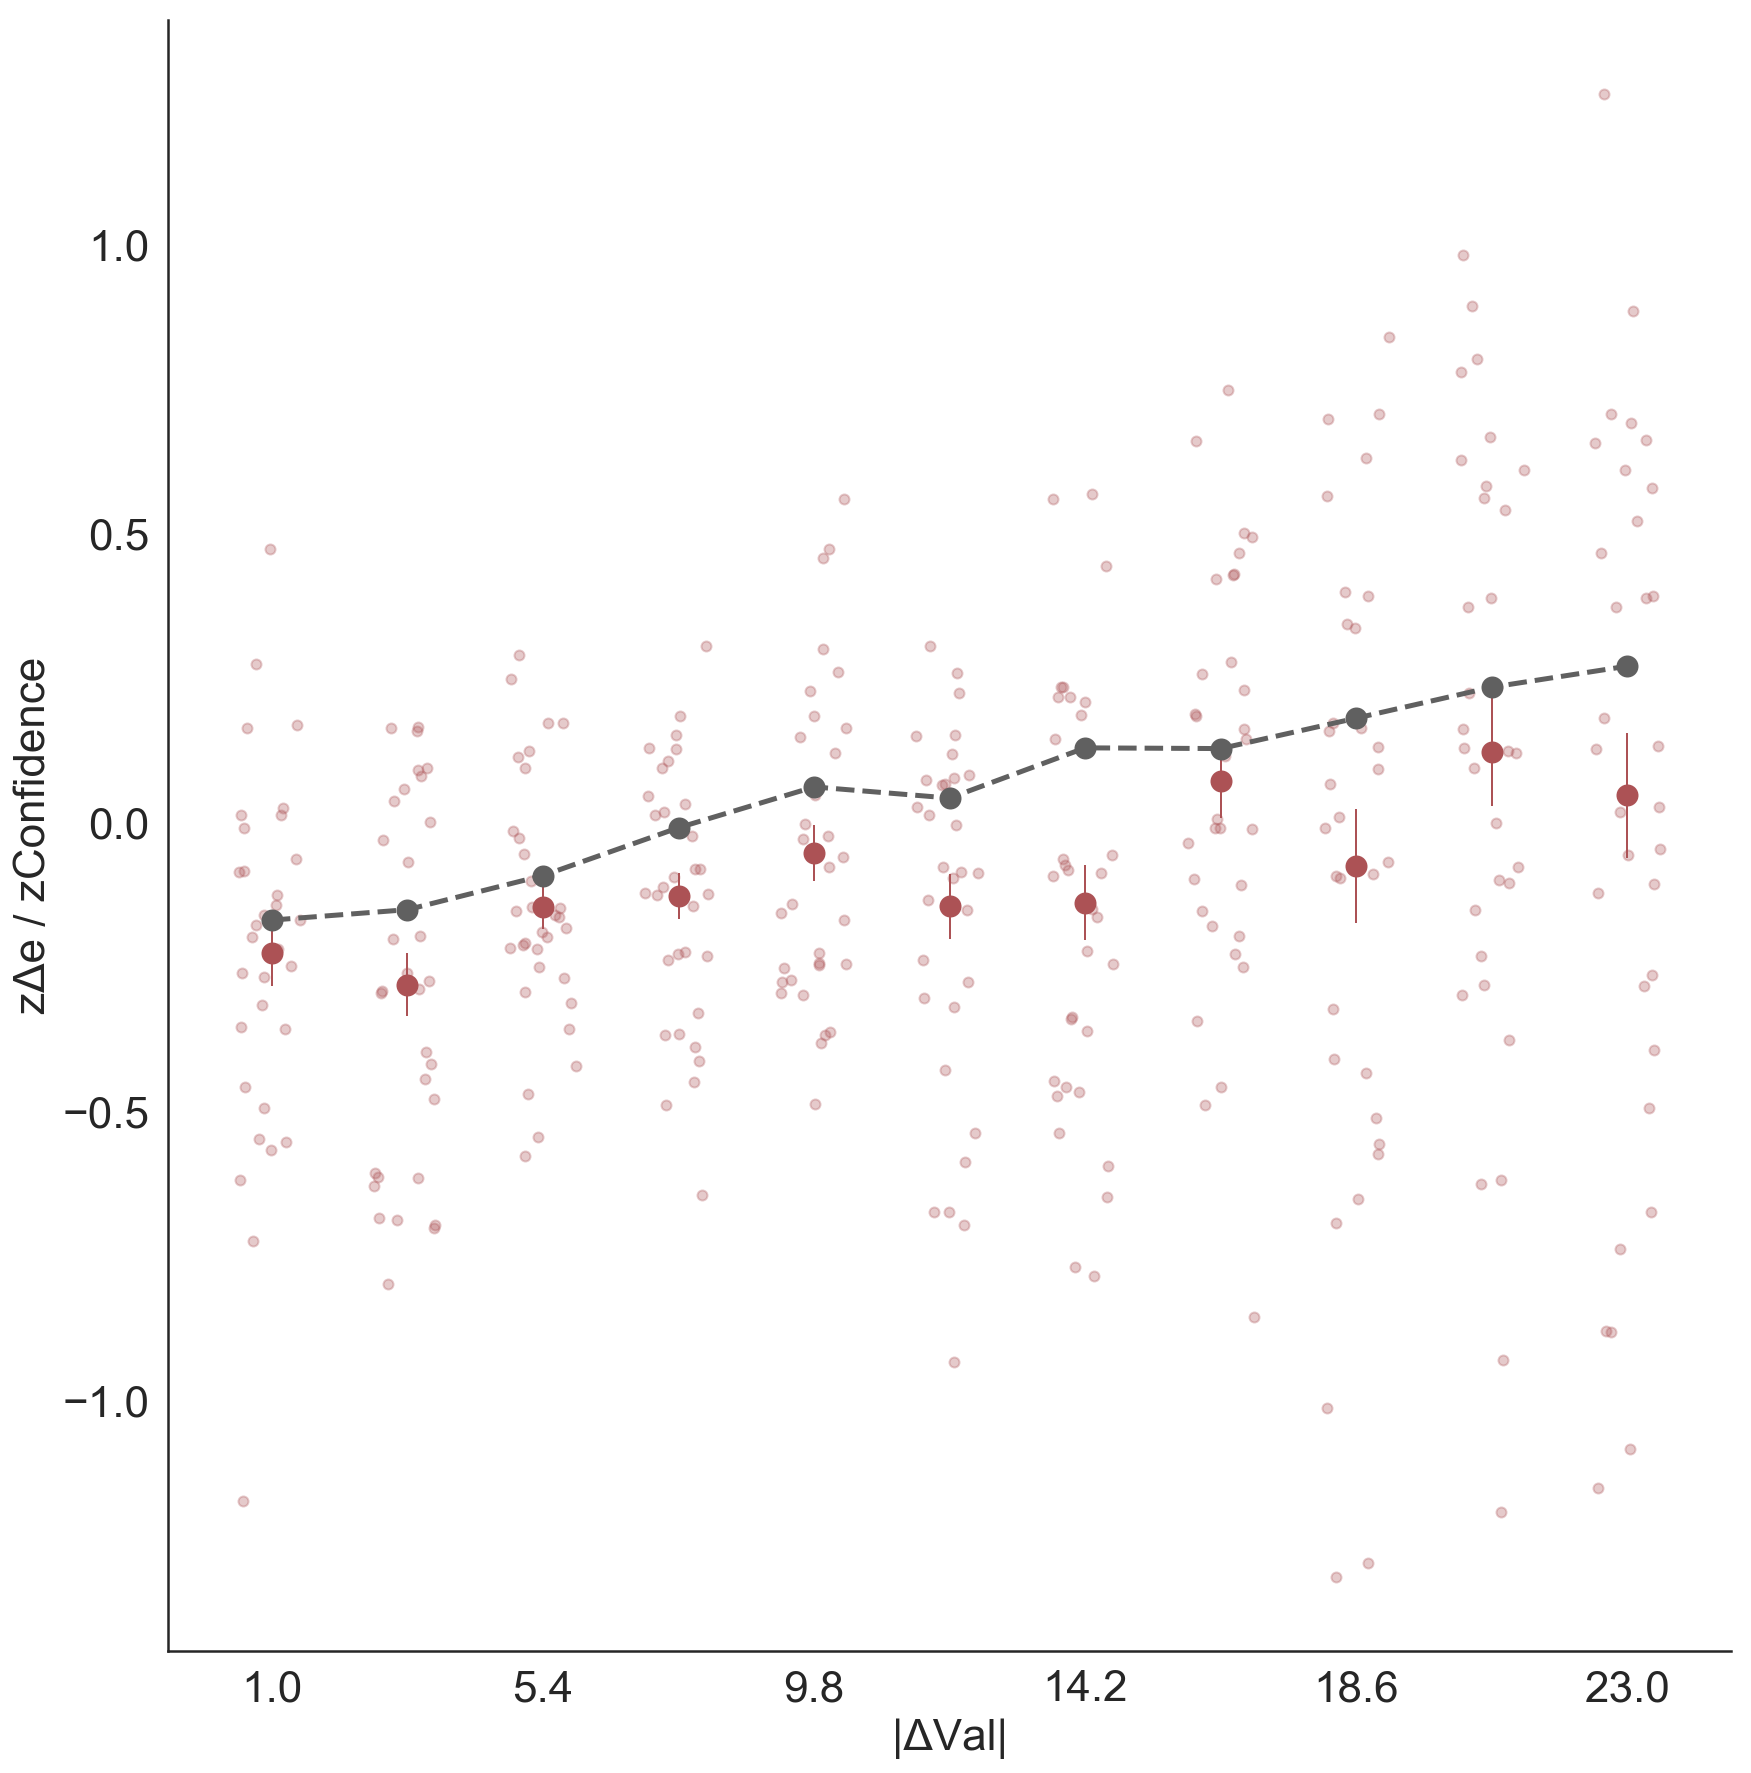

In [87]:
plot_DEv_Conf(data_simulation, xlabel_skip=2,color1 = '#AC5255')

In [88]:
data_simulation

,Part,LVal,RVal,LGaze,RGaze,AbsDVal,TotVal,AbsDEv,RTsim,Correct_sim,...,Conf_human,zConf_human,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim,TotVal_orig,zTotVal_orig
0,0,63,42,0.603448,0.396552,21,105,1.302444,3221.0,1,...,74,0.388833,-1.170501,-1.989851,2.095291,-1.615547,0.875679,0.399538,254,1.615547
1,0,126,123,0.490772,0.509228,3,249,0.603960,3176.0,1,...,54,-0.640053,1.287551,1.170501,-1.047645,1.256537,-0.674954,0.364706,110,-1.256537
2,0,123,129,0.490893,0.509107,6,252,0.361165,980.0,1,...,64,-0.125610,1.170501,1.404601,-0.523823,1.316372,-1.213958,-1.335101,107,-1.316372
3,0,116,123,0.639125,0.360875,7,239,0.889676,2405.0,1,...,84,0.903277,0.897384,1.170501,-0.349215,1.057086,-0.040664,-0.232084,120,-1.057086
4,0,131,123,0.702232,0.297768,8,254,1.170203,3085.0,1,...,44,-1.154496,1.482634,1.170501,-0.174608,1.356262,0.582104,0.294267,105,-1.356262
5,0,65,63,0.634756,0.365244,2,128,0.890782,2479.0,1,...,44,-1.154496,-1.092467,-1.170501,-1.222253,-1.156812,-0.038210,-0.174805,231,1.156812
6,0,95,93,0.602831,0.397169,2,188,0.835967,957.0,1,...,74,0.388833,0.078033,0.000000,-1.222253,0.039890,-0.159899,-1.352904,171,-0.039890
7,0,63,81,0.600783,0.399217,18,144,0.721438,1173.0,1,...,74,0.388833,-1.170501,-0.468200,1.571468,-0.837691,-0.414152,-1.185710,215,0.837691
8,0,123,125,0.475195,0.524805,2,248,0.037215,3607.0,1,...,54,-0.640053,1.170501,1.248534,-1.222253,1.236592,-1.933125,0.698320,111,-1.236592
9,0,63,72,0.436619,0.563381,9,135,0.633777,3622.0,1,...,34,-1.668940,-1.170501,-0.819350,0.000000,-1.017196,-0.608760,0.709931,224,1.017196


Done with TotVal


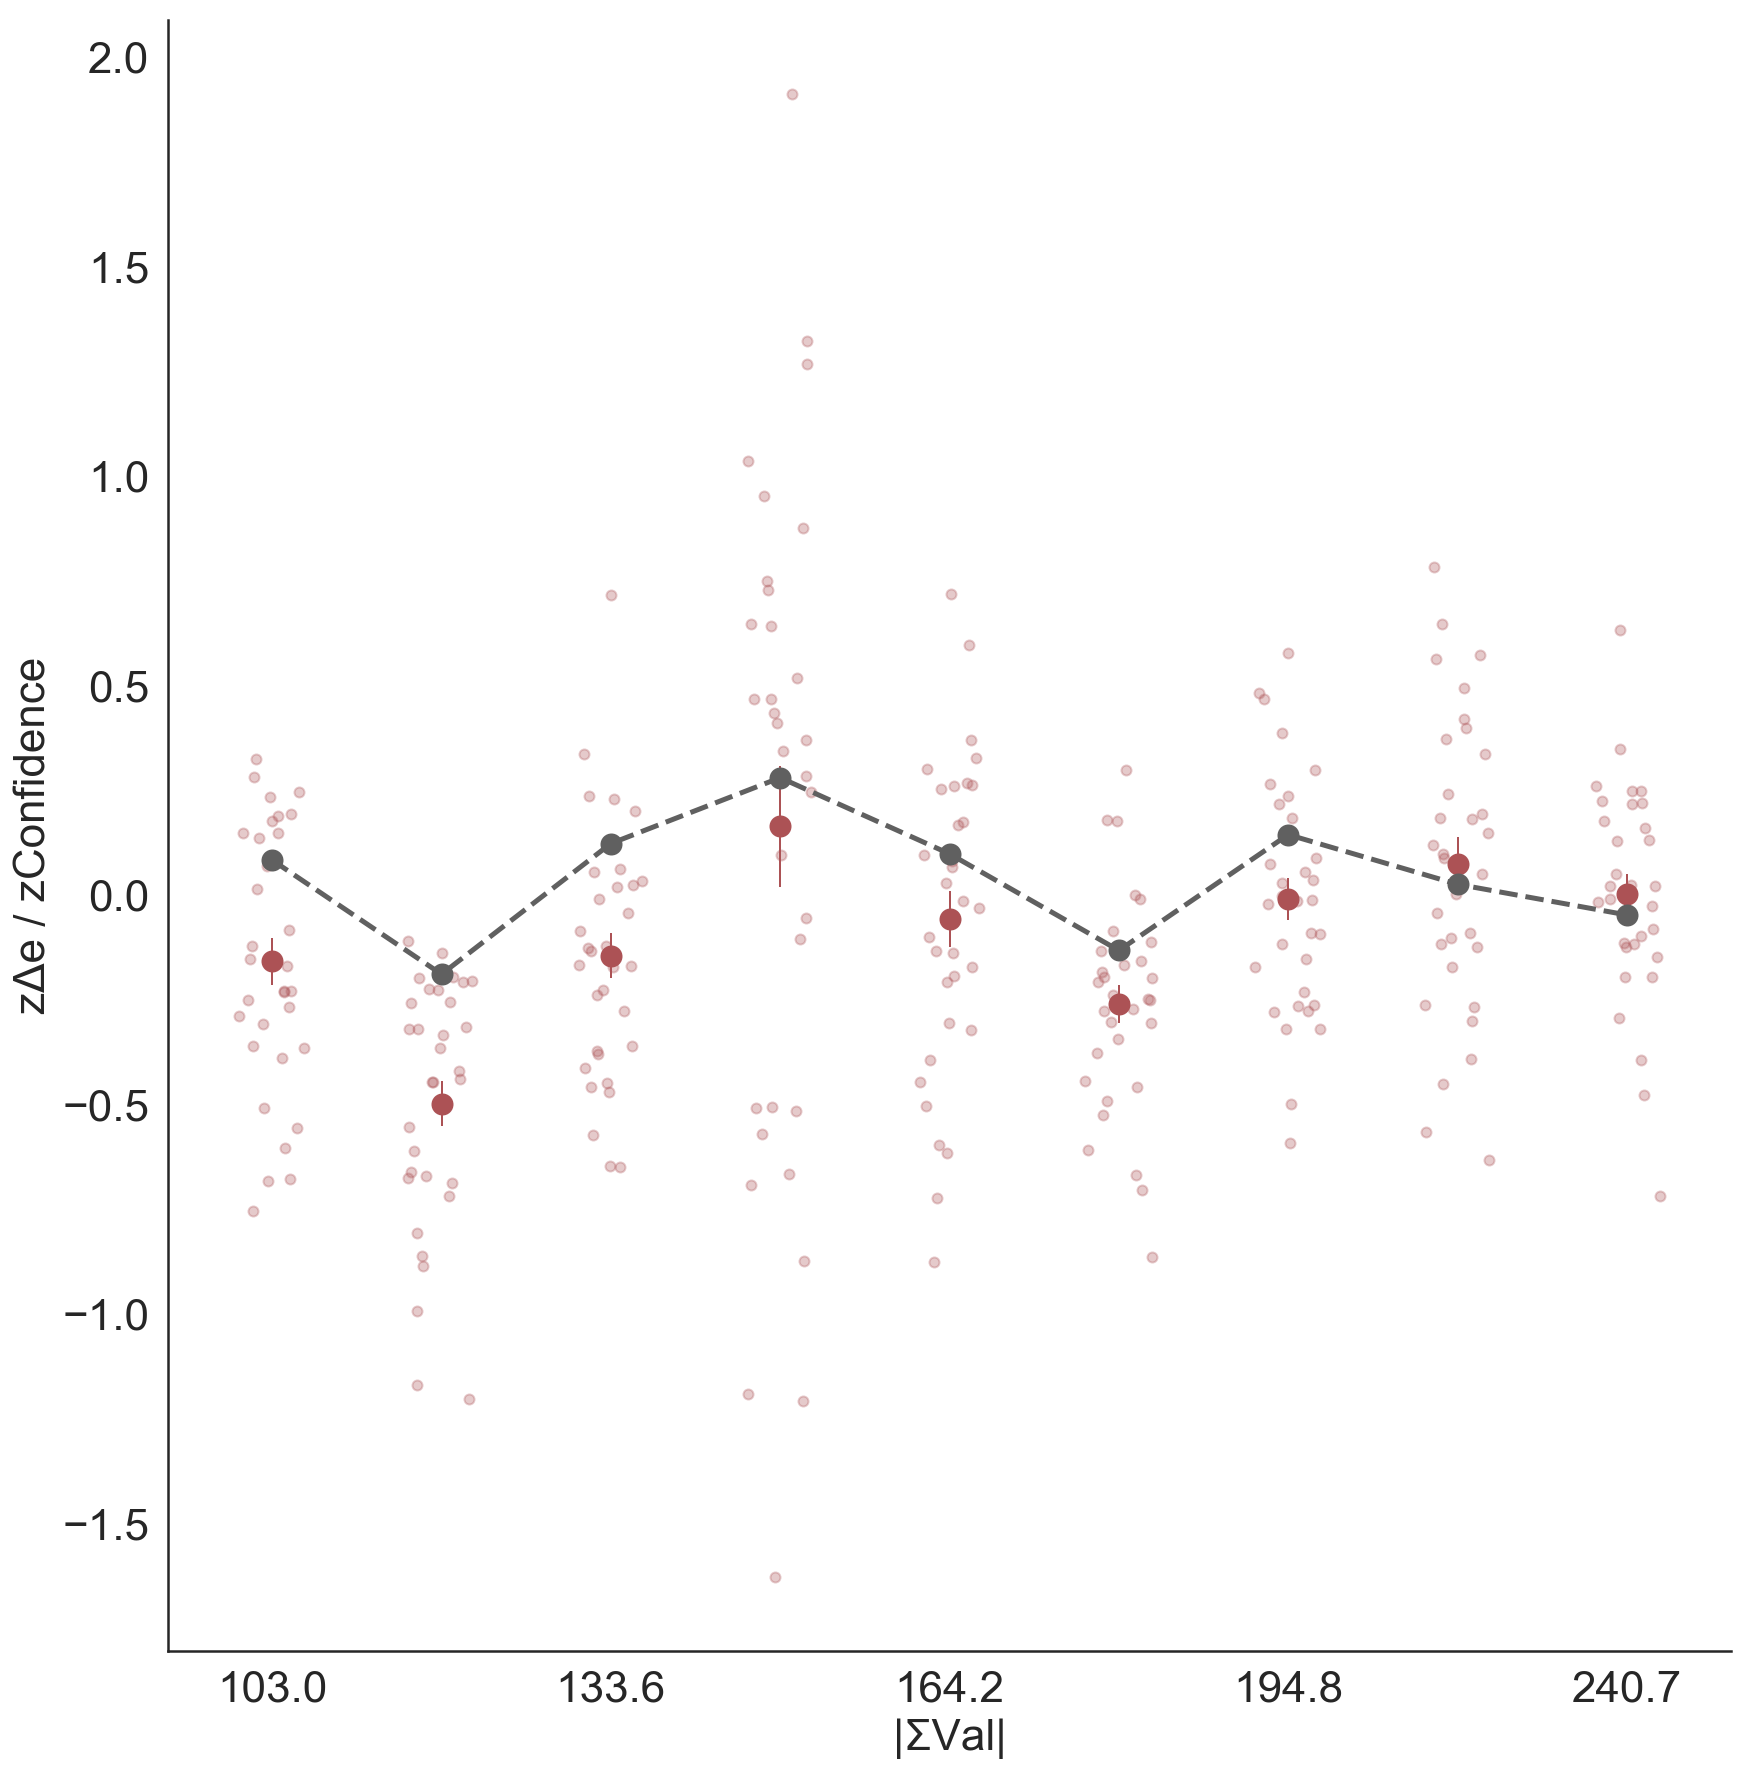

In [89]:
plot_DEv_Conf_TotVal(data_simulation,'TotVal', xlabel_skip=2,color1 = '#AC5255')

Done with TotVal


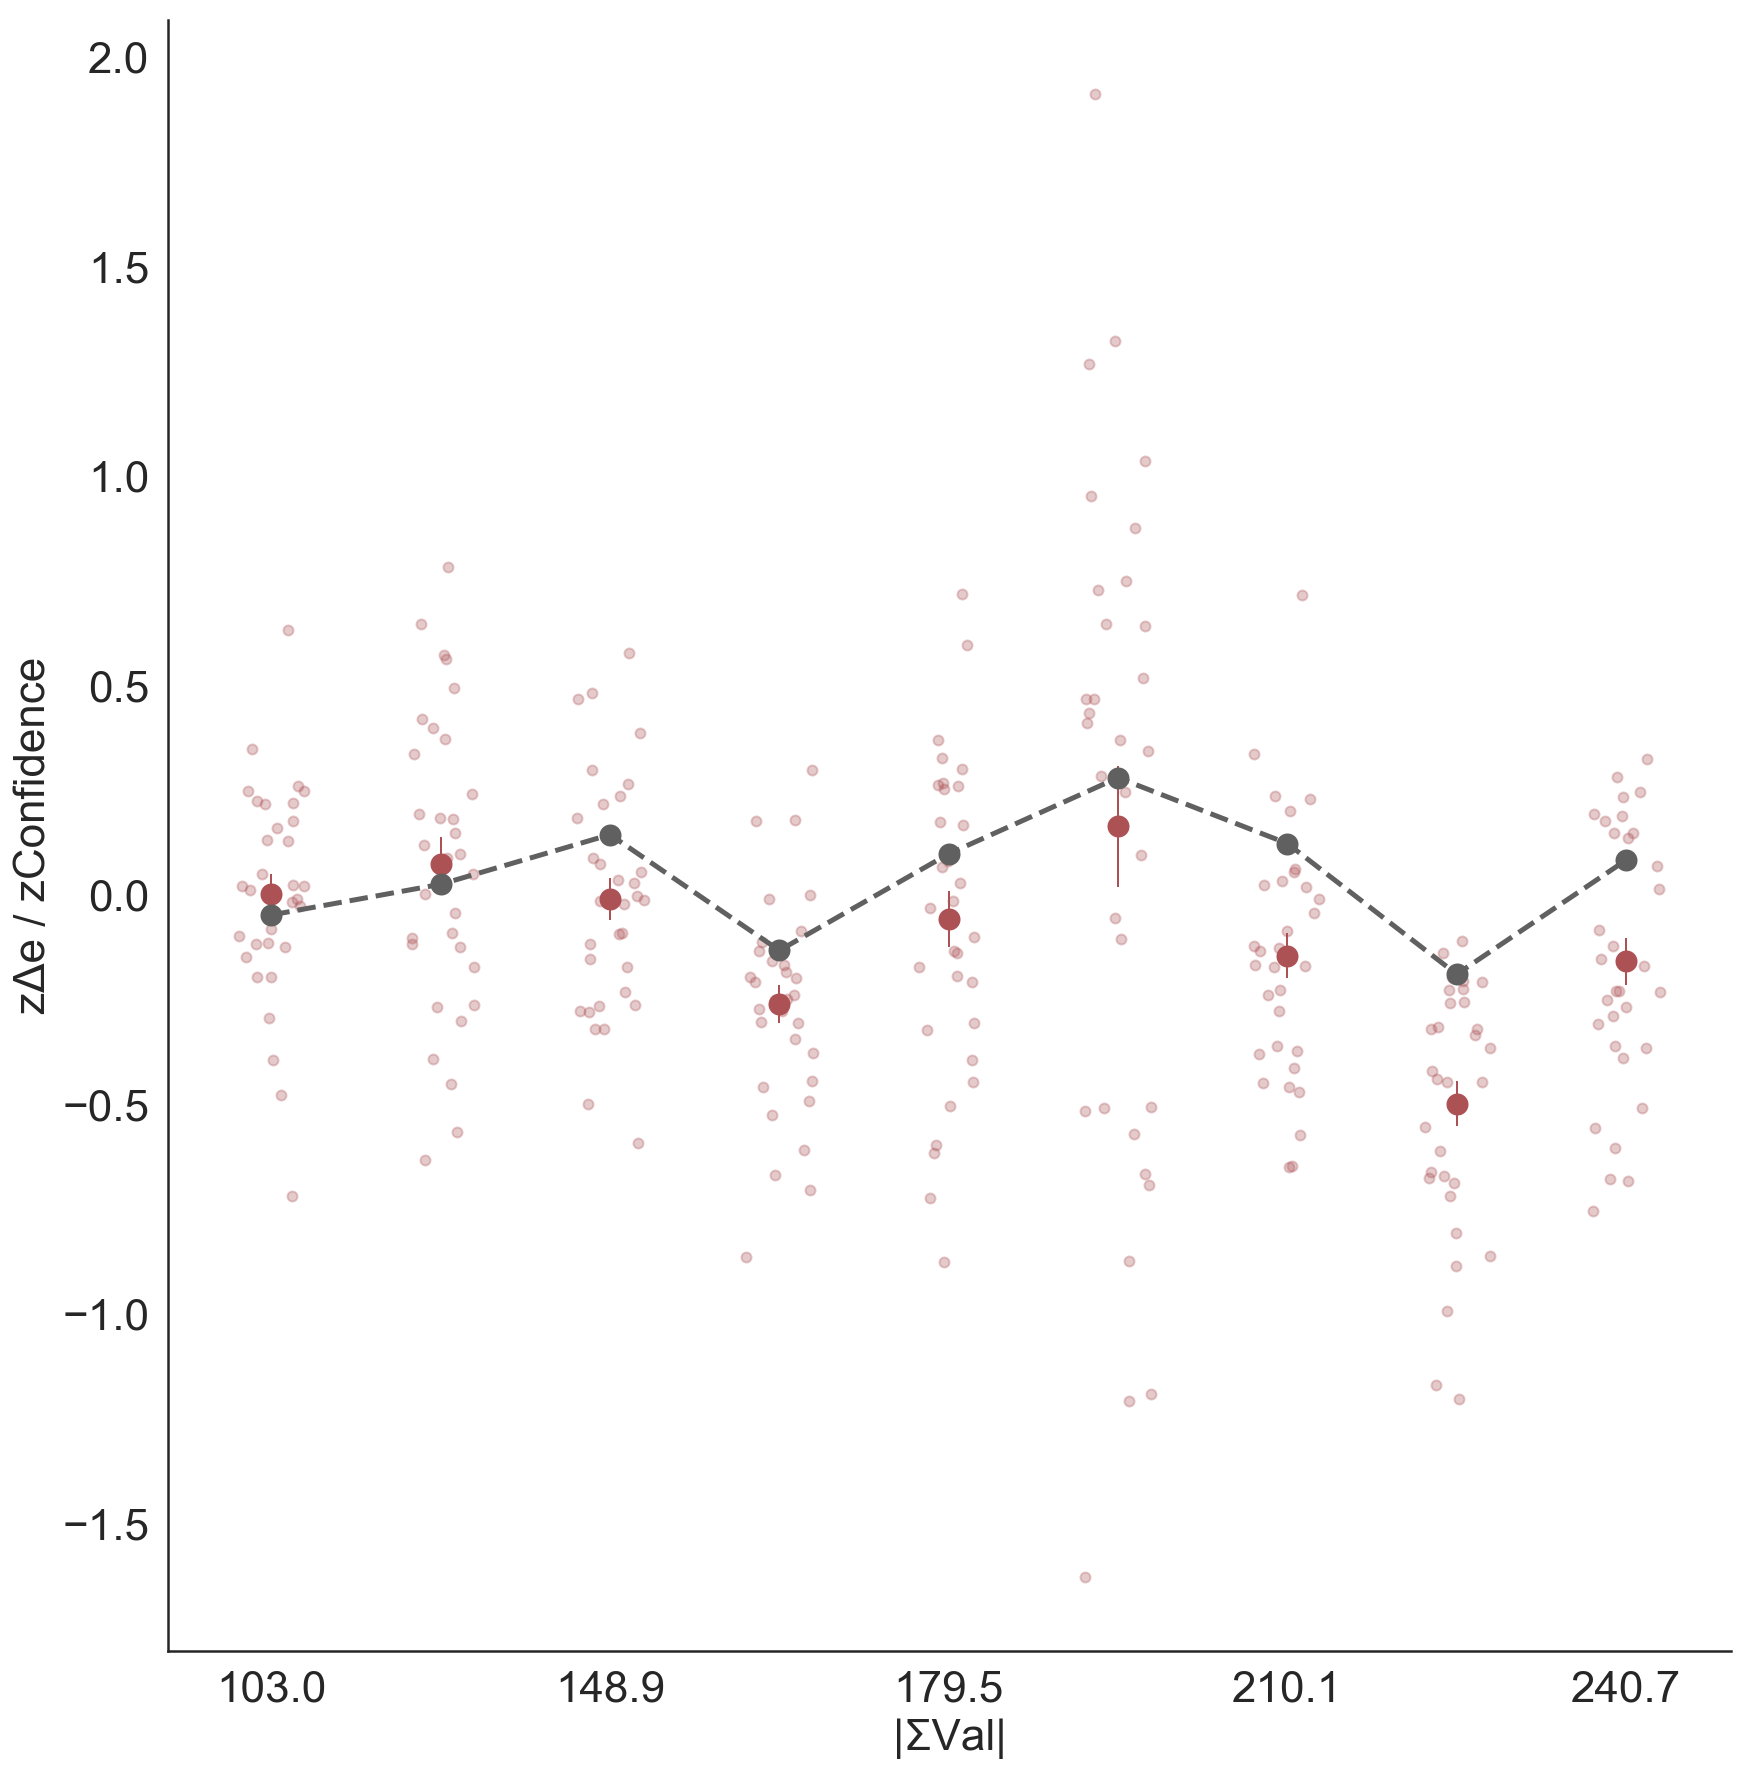

In [90]:
plot_DEv_Conf_TotVal(data_simulation,'TotVal_orig', xlims = (0,250), xlabel_skip=2,color1 = '#AC5255')

#  2. Excluding gaze information in the simulation 

In [91]:
if os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze'+sufix+'.csv')):  
        data_simulation2 = pd.read_csv(str('results/simulations_evidence/DEvidence_simulations_NoGaze'+sufix+'.csv'))

In [92]:
# repeats only once so we obtain one accumulator race for each difference in value given by participants DV used.
n_repeats = 1 # Repeats within the accumulator function
repeat_extra = 10 # Repeat outside the accumulator function
gaze_out = 1 # We DON'T want to use the gaze from the particpants

In [93]:
if not os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze_dislike_31_part.csv')):  
    Part_number = []
    LVal = []
    RVal = []
    LGaze = []
    RGaze = []
    absDVal = []
    TotVal = []
    AbsDEvid = []
    RT_sim = []
    Correct_sim = []
    Choice_sim = []
    Conf_human = []
    zConf_human = []
    
    value_tests = []
    gaze_tests = []
    
    part_id = data2['subject'].unique()
    
    for i in range(len(data_all2['Part'].unique())):    
        for k in range(0,repeat_extra):
            PartData = data2.loc[data2['subject'] == part_id[i]] # dataframe including participant GLAM data
            PartDataAll = data_all2.loc[data_all2['Part'] == part_id[i]] # dataframe including participant all data

            value_tests =np.column_stack((PartData['item_value_0'].values,PartData['item_value_1'].values))
            
            # get confidence from participants and add to the simulations datasets
            conf_tests =PartDataAll['Conf'].values
            zconf_tests =PartDataAll['zConf'].values
            
            if gaze_out == 1:
                gaze_tests = np.matlib.repmat([0.5, 0.5], len(value_tests),1)
            else:
              #  gaze_tests =np.column_stack((PartData['gaze_0'].values,PartData['gaze_1'].values))
                gaze_tests = [0, 0] # To test why it's crashing

            # We keep the same parameters for this case. 
            gamma = params_part['gamma'] [i]
            tau = params_part['tau'][i]
            v = params_part['v'][i]
            s = params_part['s'][i]
            t0 = 0
            
            parameters = [v , gamma, s, tau, t0]
            ## error_range given by the reaction time values for an individual participant
            rt_min = glam_full.data['rt'].values.min()
            rt_max = glam_full.data['rt'].values.max()
            error_range = (rt_min, rt_max)
        
            Dev_a, rts,evi_seq_0,evi_seq_1,choices = balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats)

            LVal_tmp = [item[0] for item in value_tests]
            RVal_tmp = [item[1] for item in value_tests]
            
            LGaze_tmp = [item[0] for item in gaze_tests]
            RGaze_tmp = [item[1] for item in gaze_tests]
            
            for  j in range(len(Dev_a)):
                
                Part_number.append(i)
                Conf_human.append(conf_tests[j])
                zConf_human.append(zconf_tests[j])
                
                LVal.append(LVal_tmp[j])
                RVal.append(RVal_tmp[j])
                
                LGaze.append(LGaze_tmp[j])
                RGaze.append(RGaze_tmp[j])

                absDVal.append(abs(RVal_tmp[j] -  LVal_tmp[j]))
                TotVal.append(RVal_tmp[j] +  LVal_tmp[j])
                
                if (choices[j] == 1 and value_tests[j][1]>value_tests[j][0]) or (choices[j] == 0 and value_tests[j][1]<value_tests[j][0]):
                    Correct_sim.append(1)
                else:
                    Correct_sim.append(0)
                    
                AbsDEvid.append(Dev_a[j])
                RT_sim.append(rts[j])
                Choice_sim.append(choices[j])

        print ("subj " + str(i))

    data_simulation2 =  pd.DataFrame()
    
    data_simulation2["Part"] = Part_number
    data_simulation2["LVal"] = LVal
    data_simulation2["RVal"] = RVal
    data_simulation2["LGaze"] = LGaze
    data_simulation2["RGaze"] = RGaze
    data_simulation2["AbsDVal"] = absDVal
    data_simulation2["TotVal"] = TotVal
    data_simulation2["AbsDEv"] = AbsDEvid
    data_simulation2["RTsim"] = RT_sim
    data_simulation2["Correct_sim"] = Correct_sim
    data_simulation2["Choice_sim"] = Choice_sim
    data_simulation2["Conf_human"] = Conf_human
    data_simulation2["zConf_human"] = zConf_human
    

subj 0
subj 1
subj 2
subj 3
subj 4
subj 5
subj 6
subj 7
subj 8
subj 9
subj 10
subj 11
subj 12
subj 13
subj 14
subj 15
subj 16
subj 17
subj 18
subj 19
subj 20
subj 21
subj 22
subj 23
subj 24
subj 25
subj 26
subj 27
subj 28
subj 29
subj 30
subj 31


In [94]:
data_simulation2["zLVal"] = z_score1(data_simulation2,'Part',"LVal")
data_simulation2["zRVal"] = z_score1(data_simulation2,'Part',"RVal")
data_simulation2["zAbsDVal"] = z_score1(data_simulation2,'Part',"AbsDVal")
data_simulation2["zTotVal"] = z_score1(data_simulation2,'Part',"TotVal")
data_simulation2["zAbsDEv"] = z_score1(data_simulation2,'Part',"AbsDEv")
data_simulation2["zRTsim"] = z_score1(data_simulation2,'Part',"RTsim")

In [95]:
if not  os.path.exists(str('results/simulations_evidence/DEvidence_simulations_NoGaze'+sufix+'.csv')):   
        data_simulation2.to_csv(str('results/simulations_evidence/DEvidence_simulations_NoGaze'+sufix+'.csv'))

In [96]:
data_simulation2

,Part,LVal,RVal,LGaze,RGaze,AbsDVal,TotVal,AbsDEv,RTsim,Correct_sim,Choice_sim,Conf_human,zConf_human,zLVal,zRVal,zAbsDVal,zTotVal,zAbsDEv,zRTsim
0,0,63,42,0.5,0.5,21,105,0.792555,1558.0,1,0.0,74,0.388833,-1.170501,-1.989851,2.095291,-1.615547,-0.249402,-0.830068
1,0,126,123,0.5,0.5,3,249,0.198384,3001.0,0,1.0,54,-0.640053,1.287551,1.170501,-1.047645,1.256537,-1.568393,0.178117
2,0,123,129,0.5,0.5,6,252,1.247966,2629.0,1,1.0,64,-0.125610,1.170501,1.404601,-0.523823,1.316372,0.761559,-0.081790
3,0,116,123,0.5,0.5,7,239,0.768645,2404.0,1,1.0,84,0.903277,0.897384,1.170501,-0.349215,1.057086,-0.302480,-0.238991
4,0,131,123,0.5,0.5,8,254,0.989453,4462.0,1,0.0,44,-1.154496,1.482634,1.170501,-0.174608,1.356262,0.187688,1.198878
5,0,65,63,0.5,0.5,2,128,0.383128,4358.0,1,0.0,44,-1.154496,-1.092467,-1.170501,-1.222253,-1.156812,-1.158282,1.126216
6,0,95,93,0.5,0.5,2,188,0.573663,6774.0,1,0.0,74,0.388833,0.078033,0.000000,-1.222253,0.039890,-0.735318,2.814209
7,0,63,81,0.5,0.5,18,144,1.426016,3603.0,1,1.0,74,0.388833,-1.170501,-0.468200,1.571468,-0.837691,1.156808,0.598718
8,0,123,125,0.5,0.5,2,248,1.467002,1753.0,0,0.0,54,-0.640053,1.170501,1.248534,-1.222253,1.236592,1.247792,-0.693827
9,0,63,72,0.5,0.5,9,135,0.787465,2083.0,1,1.0,34,-1.668940,-1.170501,-0.819350,0.000000,-1.017196,-0.260702,-0.463265


## Since for dislike we have that TotVal represents the inverted value we take it back to the original denomination

In [97]:
data_simulation2['TotVal_orig'] = np.max(data_simulation['TotVal'].unique()) - data_simulation['TotVal'] +np.min(data_simulation['TotVal'].unique())
data_simulation2["zTotVal_orig"] = z_score1(data_simulation2,'Part',"TotVal_orig")


Pearson's r = -0.028 p =  0.0


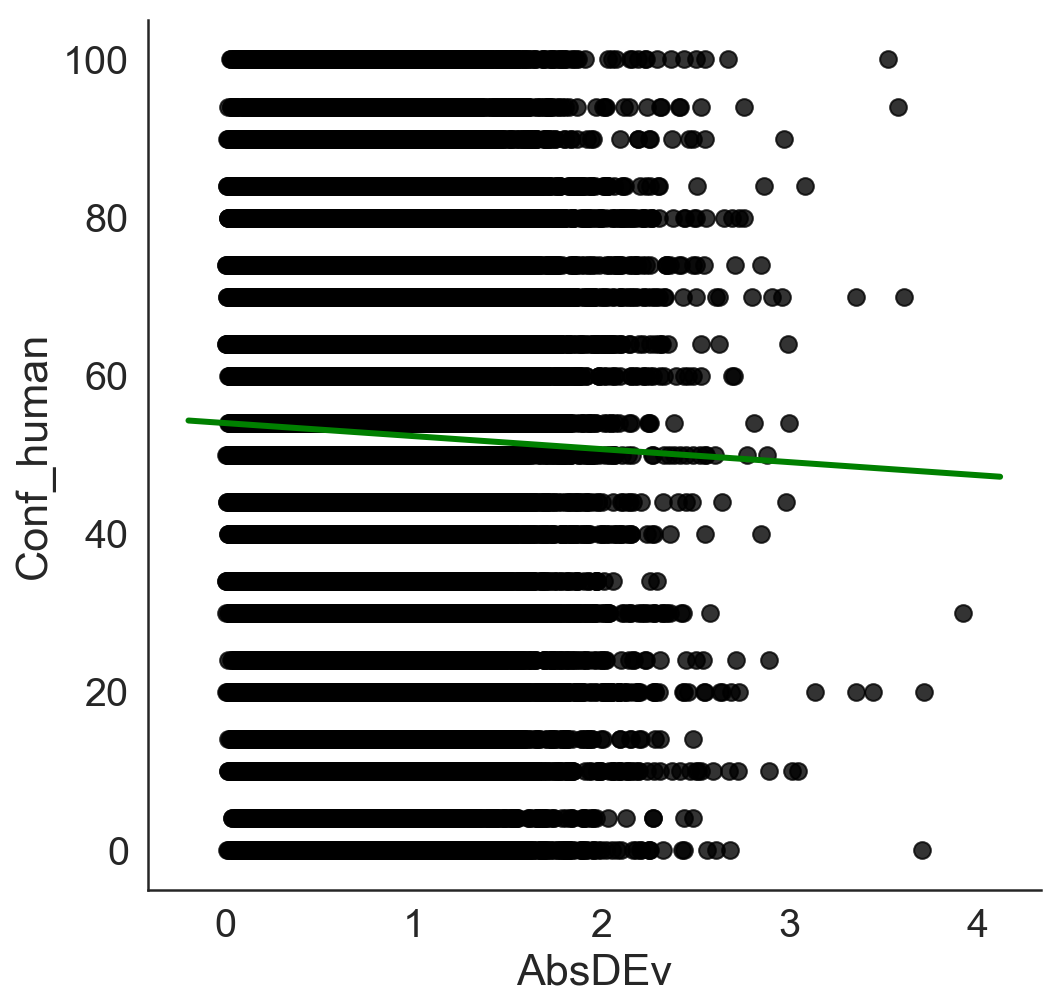

Pearson's r = 0.029 p =  0.0


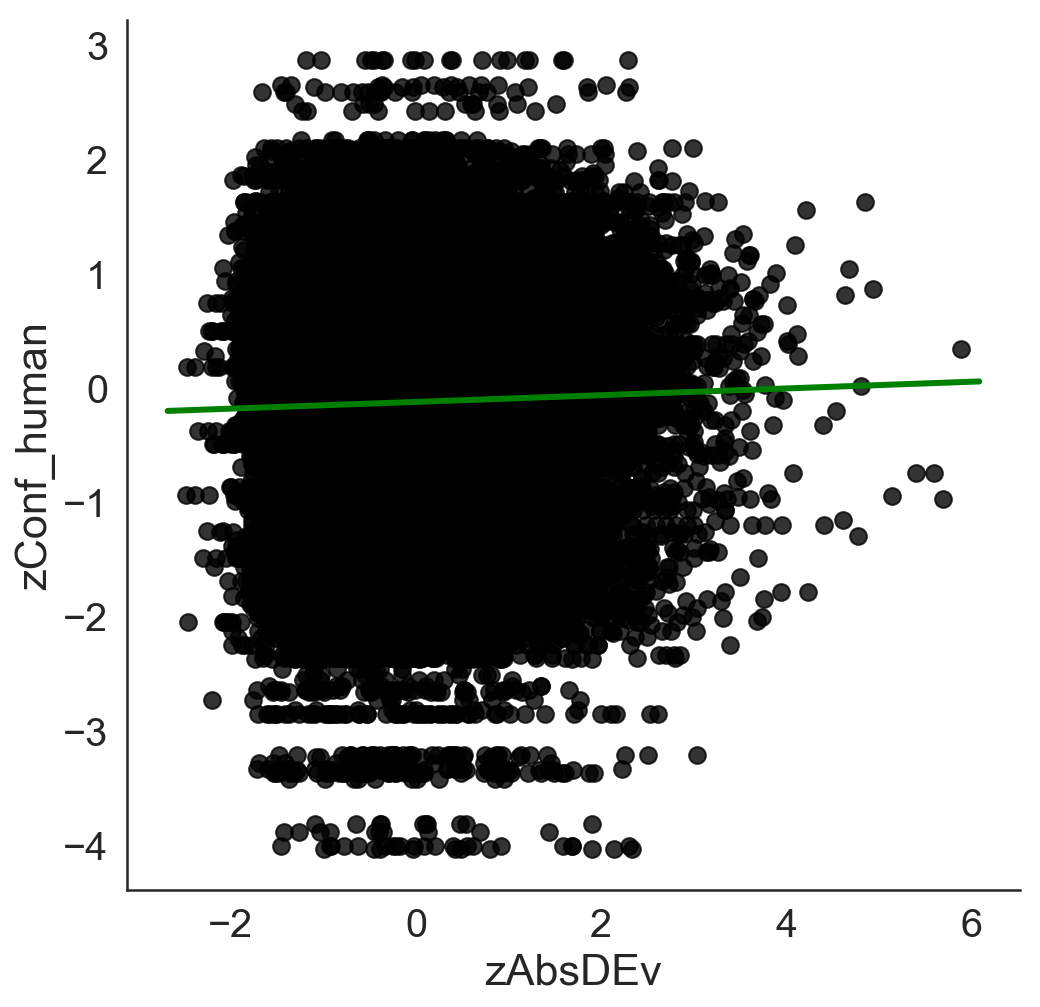

In [98]:
correl_plot(data_simulation2,'AbsDEv', "AbsDEv",'Conf_human','Conf_human')
correl_plot(data_simulation2,'zAbsDEv', "zAbsDEv",'zConf_human','zConf_human')

In [99]:
%%R -i data_simulation2
d <- data_simulation2

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


BIC: 107238.9
Call:  glm(formula = zAbsDEv ~ zAbsDVal + zTotVal_orig + zRTsim, data = d)

Coefficients:
 (Intercept)      zAbsDVal  zTotVal_orig        zRTsim  
  -4.068e-16     1.872e-01    -6.585e-03    -8.636e-02  

Degrees of Freedom: 38399 Total (i.e. Null);  38396 Residual
Null Deviance:	    38400 
Residual Deviance: 36650 	AIC: 107200


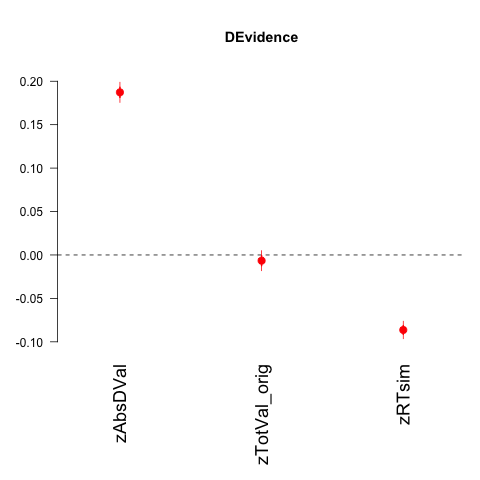

In [100]:
%%R    
title_plot = "DEvidence"
ModelChoice_1 <- glm(zAbsDEv ~ zAbsDVal + zTotVal_orig + zRTsim  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

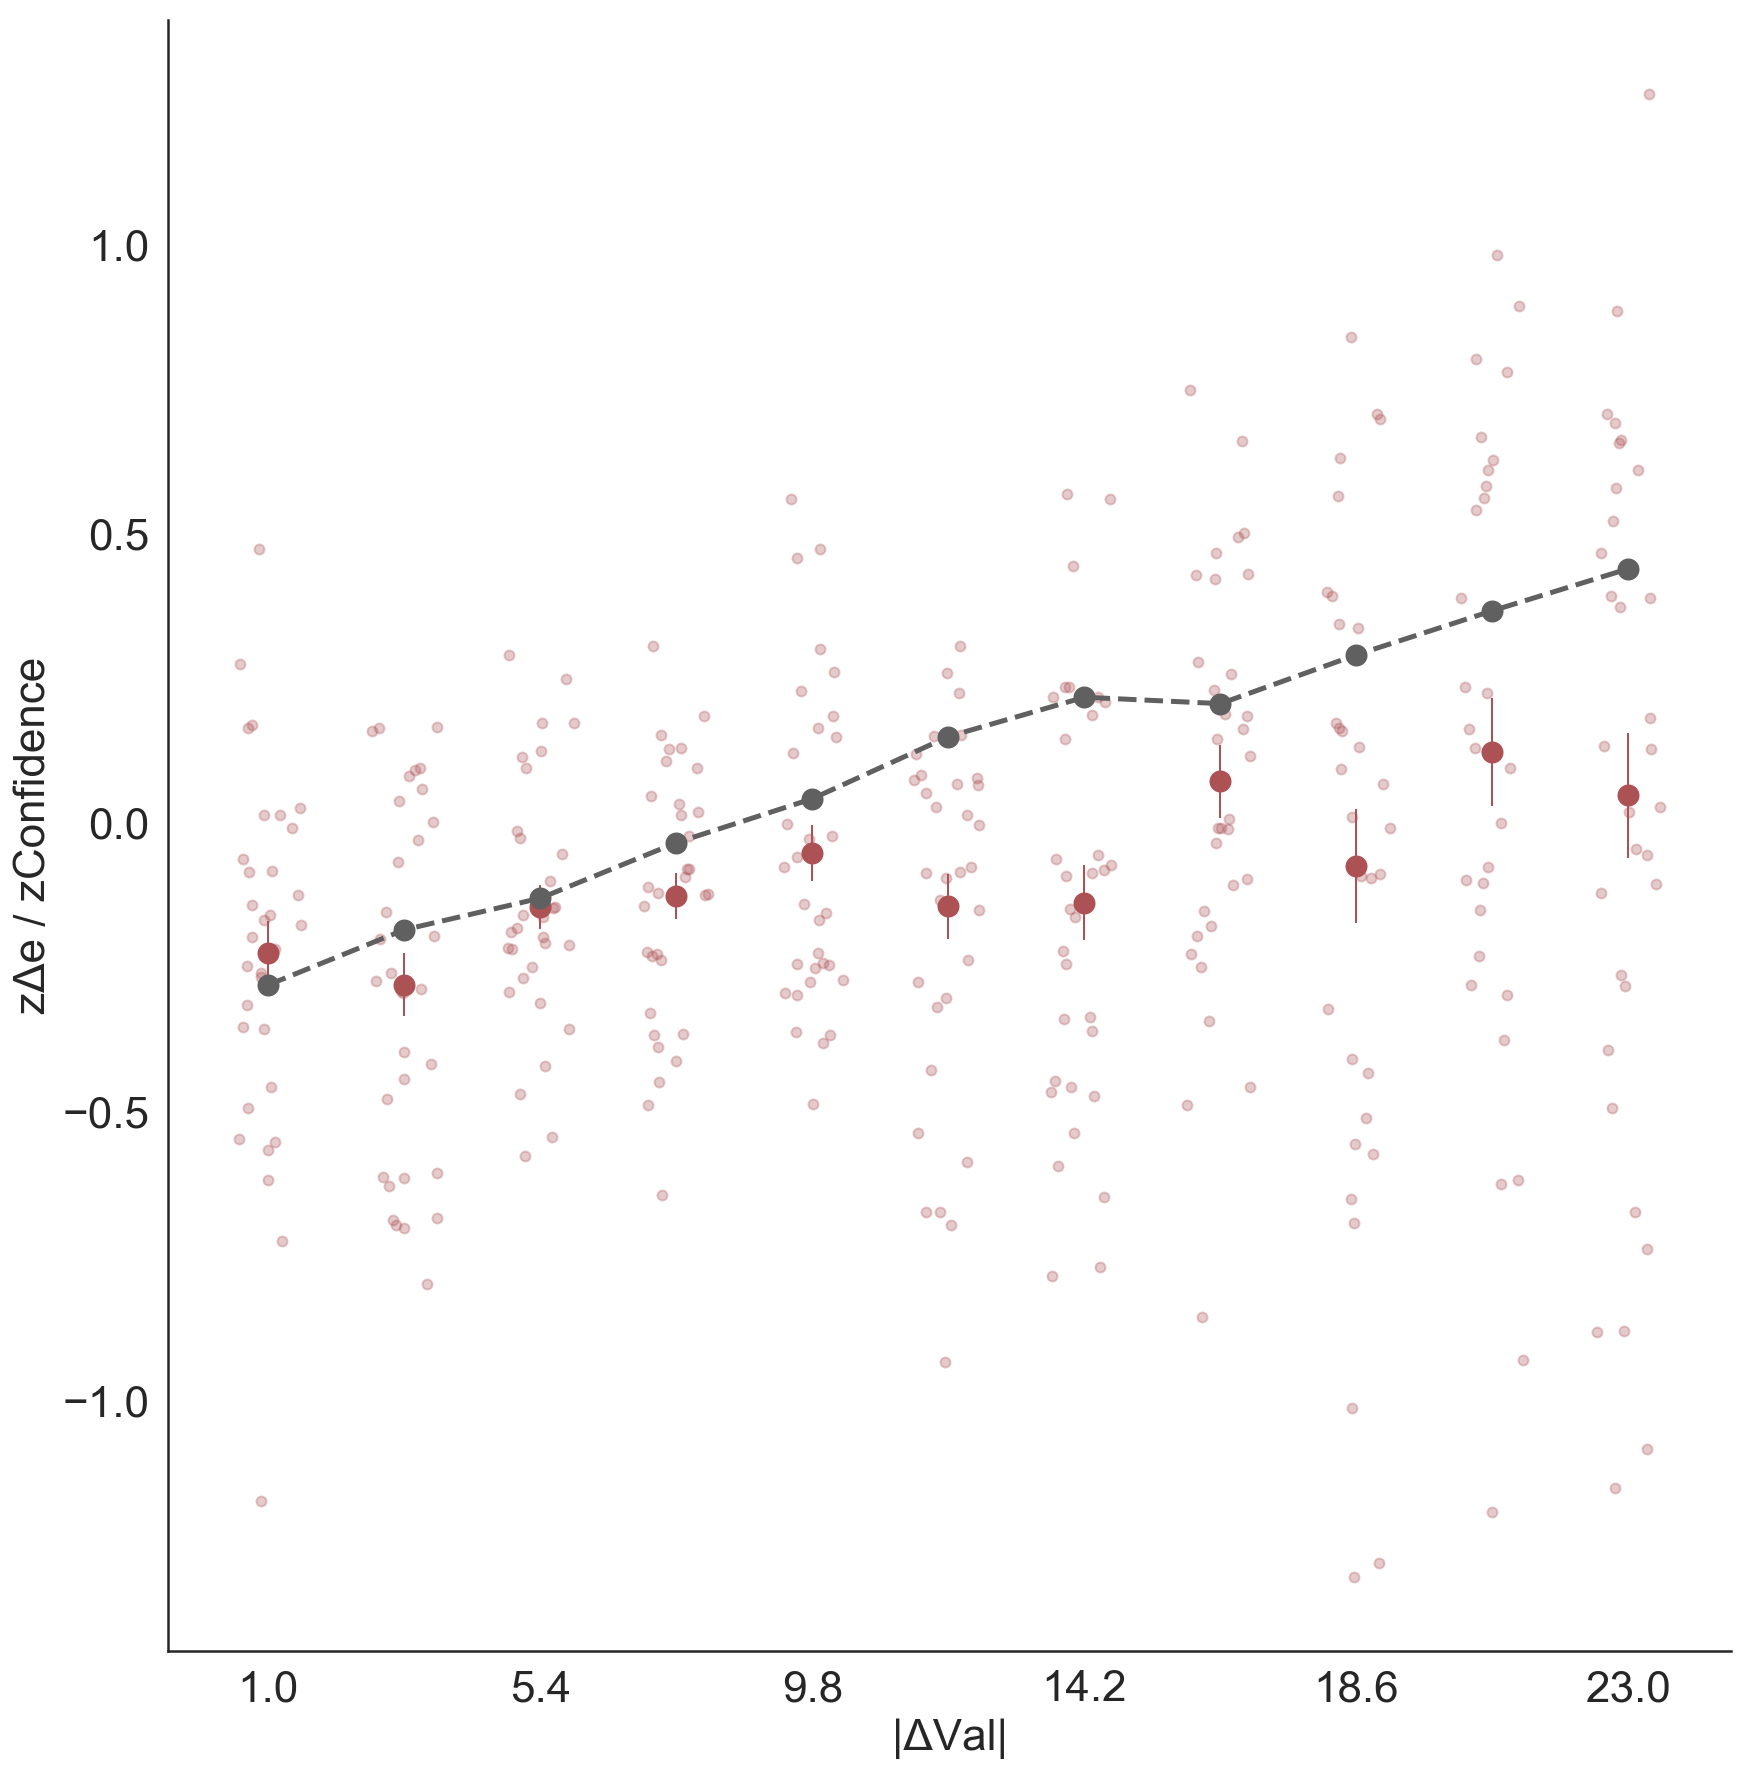

In [101]:
plot_DEv_Conf(data_simulation2, xlabel_skip=2,color1 = '#AC5255')

Done with TotVal


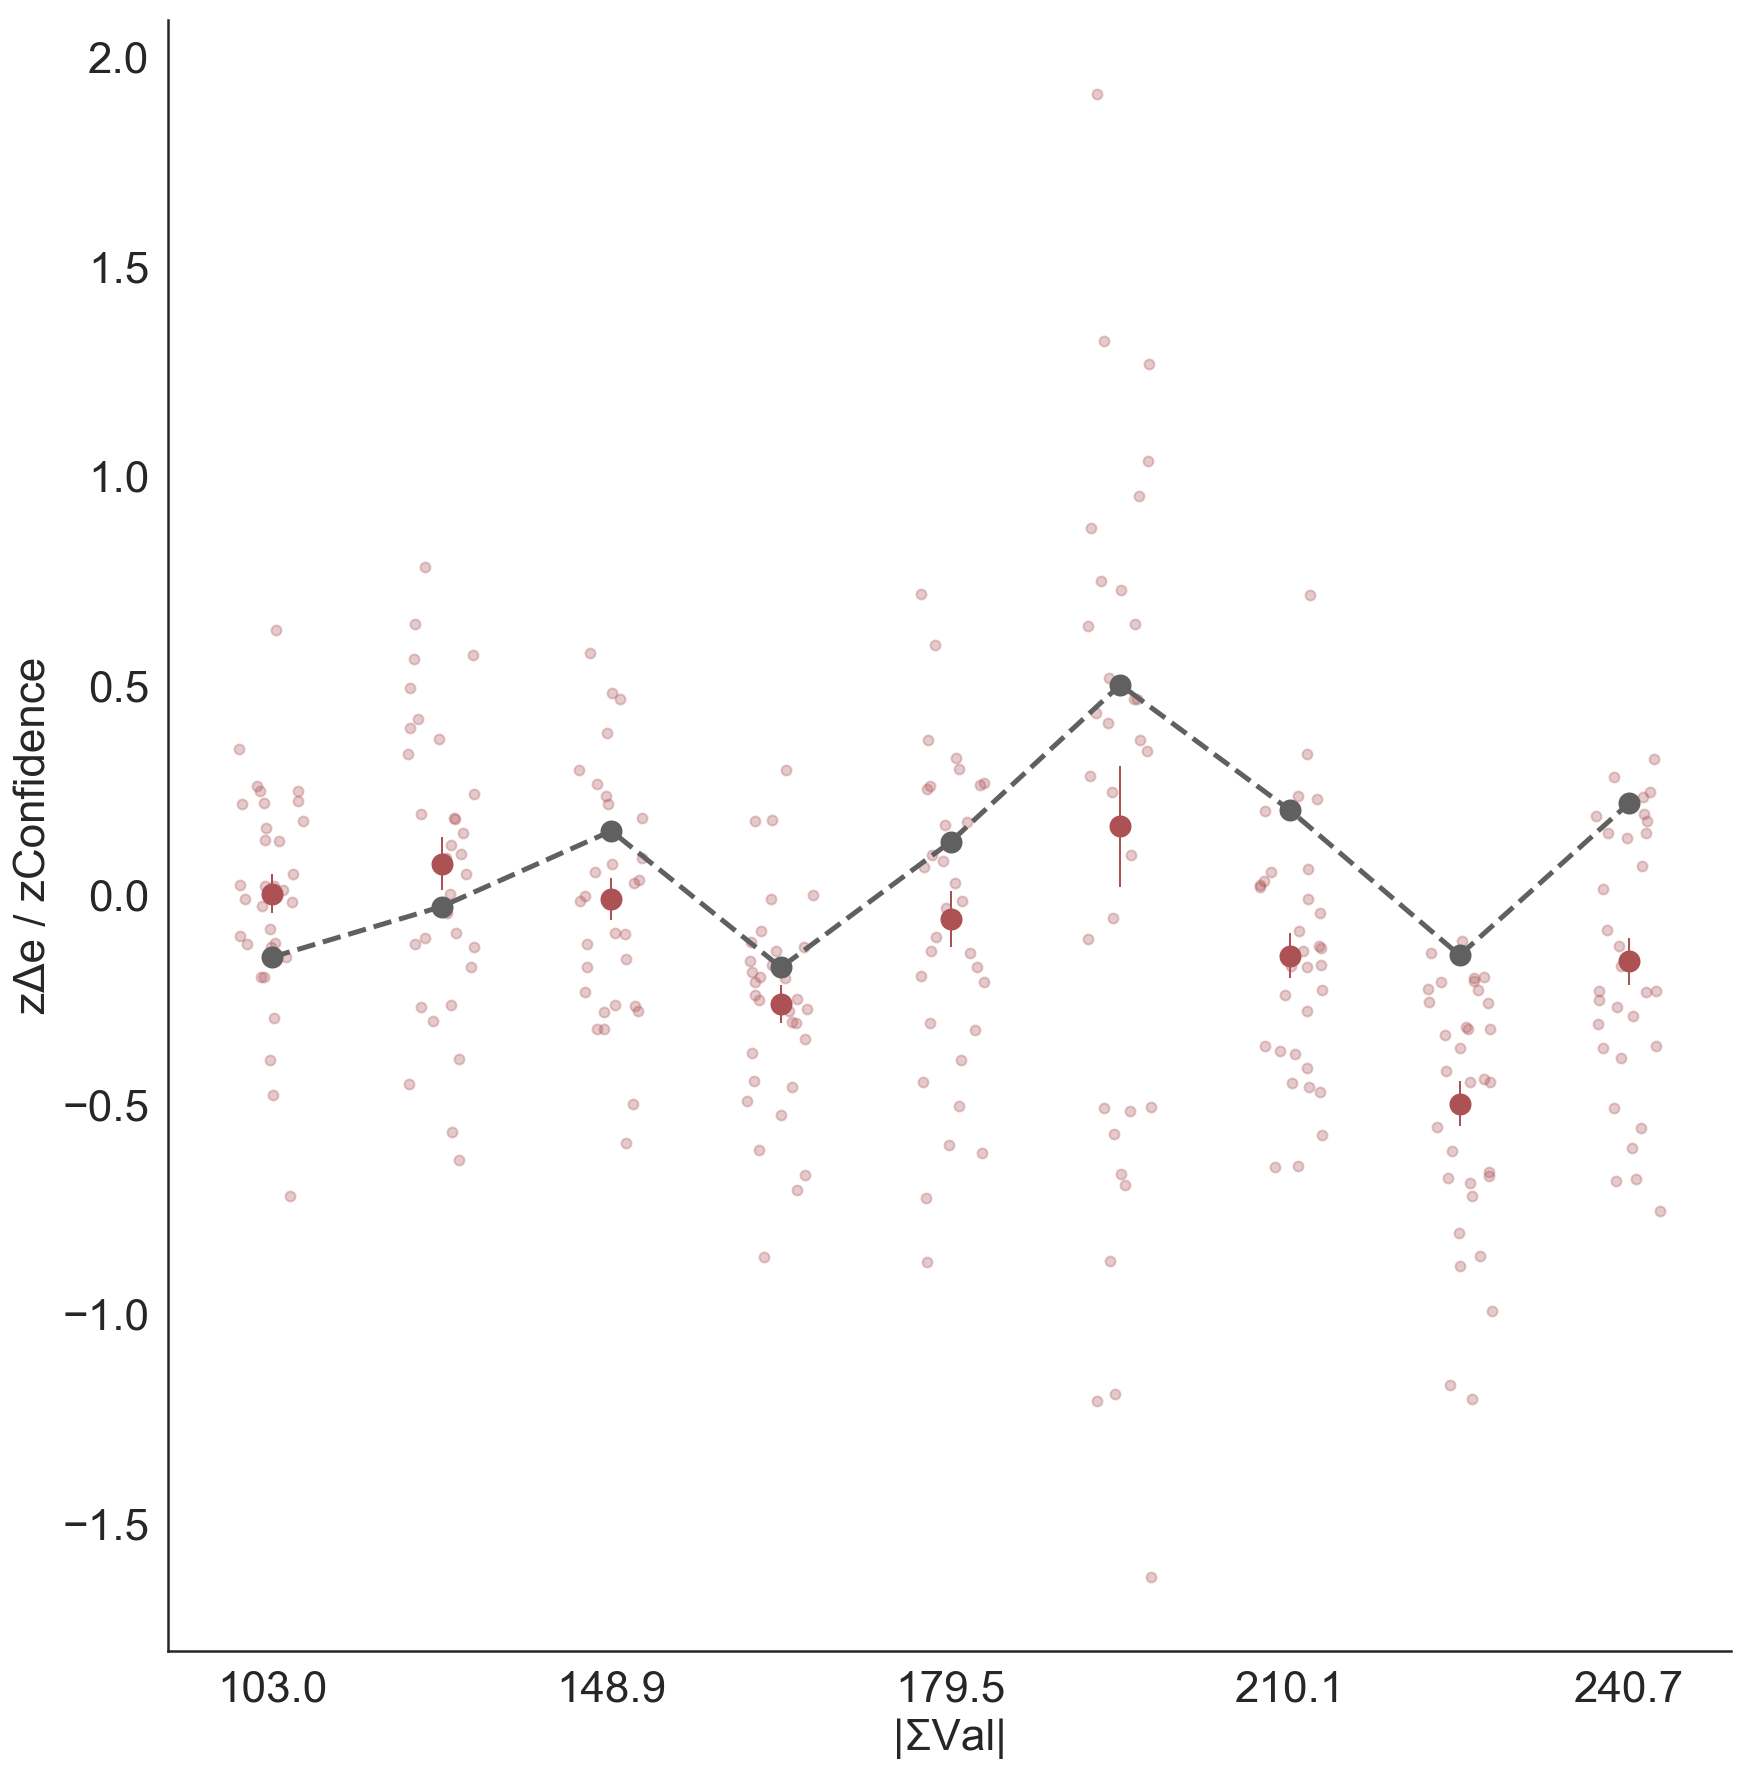

In [102]:
plot_DEv_Conf_TotVal(data_simulation2,'TotVal_orig' , xlabel_skip=2,color1 = '#AC5255')

# ----------------------------------------------------------------------

# Is DGaze linked to DVal?

we use the data from simulation 2 since we re taking human data for all the participants those relationships are maintained.

In [ ]:
data_GazeVal =  pd.DataFrame()
data_GazeVal["RGaze"] = data.gaze_1 
data_GazeVal["LGaze"] = data.gaze_0 
data_GazeVal["DGaze"] = data.gaze_1 - data.gaze_0
data_GazeVal["AbsDGaze"] = abs(data.gaze_1 - data.gaze_0)
data_GazeVal["zRValue"] = data_all.zRVal.values
data_GazeVal["zLValue"] = data_all.zLVal.values
data_GazeVal["zTotValue"] = data_all.zTotVal.values
data_GazeVal["zDValue"] = data_all.zDVal.values
data_GazeVal["zAbsDValue"] = data_all.zAbsDVal.values
data_GazeVal["DValue"] = data_all.DVal.values
data_GazeVal["zConf"] = data_all.zConf.values



In [ ]:
len(data_GazeVal["zDValue"].values)

# Add bin column for Value

In [ ]:
# data_GazeVal["zDVal_bin"] = pd.qcut(data_GazeVal["zDValue"].values, 10, labels=[0, 1, 2,3,4,5,6,7,8,9])
data_GazeVal["zDVal_bin"] = pd.to_numeric(pd.qcut(data_GazeVal["zDValue"].values, 5, labels=[0, 1, 2,3,4]))
data_GazeVal["zAbsDVal_bin"] = pd.to_numeric(pd.qcut(data_GazeVal["zAbsDValue"].values, 5, labels=[0, 1, 2,3,4]))

data_GazeVal["zHighVal"] = data_GazeVal[["zRValue", "zLValue"]].max(axis=1)

# Add bin column for Gaze

In [ ]:
# data_GazeVal["zDVal_bin"] = pd.qcut(data_GazeVal["zDValue"].values, 10, labels=[0, 1, 2,3,4,5,6,7,8,9])
data_GazeVal["zDGaze_bin"] = pd.to_numeric(pd.qcut(data_GazeVal["DGaze"].values, 5, labels=[0, 1, 2,3,4]))
data_GazeVal["zAbsDGaze_bin"] =pd.to_numeric( pd.qcut(data_GazeVal["AbsDGaze"].values, 5, labels=[0, 1, 2,3,4]))

data_GazeVal["zHighGaze"] = data_GazeVal[["RGaze", "LGaze"]].max(axis=1)

In [ ]:
data_GazeVal.head()

In [ ]:
correl_plot(data_GazeVal,'zDValue', "zDValue",'zTotValue','zTotValue')

In [ ]:
correl_plot(data_GazeVal,'DGaze', "DGaze",'zDValue','zDValue')
correl_plot(data_GazeVal,'AbsDGaze', "AbsDGaze",'zAbsDValue','zAbsDValue')
correl_plot(data_GazeVal,'AbsDGaze', "AbsDGaze",'zTotValue','zTotValue')

In [ ]:
correl_plot(data_GazeVal,'AbsDGaze', "AbsDGaze",'zHighVal','zHighVal')

# Tiny yet significant correlation between |DGaze| and Total Value

In [ ]:
%%R -i data_GazeVal
d <- data_GazeVal

In [ ]:
%%R    
title_plot = "DGaze"
ModelChoice_1 <- glm(DGaze ~ zRValue + zLValue  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

In [ ]:
%%R    
title_plot = "DGaze"
ModelChoice_1 <- glm(DGaze ~ zDValue + zTotValue+ zDValue:zTotValue  , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

In [ ]:
%%R    
title_plot = "|DGaze|"
ModelChoice_1 <- glm(AbsDGaze ~ zAbsDValue +zTotValue , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

## Is DGaze linked to TotValue ?


In [ ]:
%%R    
title_plot = "|DGaze|"
ModelChoice_1 <- glm(AbsDGaze ~ zAbsDValue +zTotValue , data= d)
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1choice = BIC(ModelChoice_1)
cat("BIC:" , BIC1choice)
ModelChoice_1

If we split by constant DVal...

## Relationship Total Value and DGaze, splitting for DV

In [ ]:

for i in range(5):
    data_GazeVal_extract = data_GazeVal.loc[data_GazeVal['zDVal_bin'] == i] # 1 = Like, 2 = Dislike
    print ('DVal = ' + str(i))
    correl_plot(data_GazeVal_extract,'zTotValue','zTotValue','AbsDGaze', "AbsDGaze") 

## Relationship Total Value and DGaze, splitting for AbsDV

In [ ]:

for i in range(5):
    data_GazeVal_extract = data_GazeVal.loc[data_GazeVal['zAbsDVal_bin'] == i] # 1 = Like, 2 = Dislike
    print ('DVal = ' + str(i))
    correl_plot(data_GazeVal_extract,'zTotValue','zTotValue','AbsDGaze', "AbsDGaze") 

We observe a (tiny) effect of Total Value over the magnitude in DGaze. That means that the bigger the difference in value also the magnitude of DGaze will increment. From the correlation above, we see that gaze tends to be aliged with the item of max value.
Therefore, in terms of accumulators, we have that the biggest the total value, the difference in gaze will increase favouring the item with higher value. Given the model, when the selected item is not fixated the rate of accumulation decreases keeping the rate of accumulation of the higher item. 

𝐴 = 𝑔 × 𝑟 + (1 − 𝑔 ) × 𝛾𝑟   

R*left = A_left - A_right   

R*right = A_right - A_left    

Then, the R* will get into the logistic regression to get the accumulation rate. However, given that tau is the same for all, is Rstar the one that should contain the TotValue effect over DEvidence.
The atenuation effect for DEvidence that we observe  for higher TotVal can be explained by the asintote that we have at the extremes of sigmoid function. 

Using mean gamma from params ( negative gamma) that means that there is a leak towards the non fixated item which should increase more the difference between the attended vs unattended item. (Leak: you are substracting evidence when the item is not attended)


In [ ]:
# No gaze bias
gamma_t= -0.2
gL_t=0.5
LItem_t = 3 
RItem_t = 2 
AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t

R_starR = AR_t - AL_t
R_starL = AL_t - AR_t
R_starL

In [ ]:
# No gaze bias
gamma_t= -0.2
gL_t=0.5
LItem_t = 4
RItem_t = 3 
AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t

R_starR = AR_t - AL_t
R_starL = AL_t - AR_t
R_starL

In [ ]:
# No gaze bias
gamma_t= -0.2
gL_t=0.5
LItem_t = 5
RItem_t = 4 
AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t

R_starR = AR_t - AL_t
R_starL = AL_t - AR_t
R_starL

Without gaze bias we don't observe an influence of TotalValue over the result. But if we include the gaze bias. We observe an increase in the magnitude of R*

In [ ]:
# gaze bias towards the higher item
gamma_t= 0.5
gL_t=0.7
LItem_t = 3 
RItem_t = 2 
AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t

R_starR = AR_t - AL_t
R_starL = AL_t - AR_t
R_starL

In [ ]:
# gaze bias towards the higher item
gamma_t= 0.5
gL_t=0.7
LItem_t = 4 
RItem_t = 3 
AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t

R_starR = AR_t - AL_t
R_starL = AL_t - AR_t
R_starL

In [ ]:
# gaze bias towards the higher item
gamma_t= 0.5
gL_t=0.7
LItem_t = 5 
RItem_t = 4 
AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t

R_starR = AR_t - AL_t
R_starL = AL_t - AR_t
R_starL

And additionally, if we also include the negative gamma parameter, as the one observed in our participants, the magnitude just increases

In [ ]:
# gaze bias towards the higher item
gamma_t= -0.2
gL_t=0.7
LItem_t = 3 
RItem_t = 2 
AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t

R_starR = AR_t - AL_t
R_starL = AL_t - AR_t
R_starL

In [ ]:
# gaze bias towards the higher item
gamma_t= -0.2
gL_t=0.7
LItem_t = 4 
RItem_t = 3 
AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t

R_starR = AR_t - AL_t
R_starL = AL_t - AR_t
R_starL

In [ ]:
# gaze bias towards the higher item
gamma_t= -0.2
gL_t=0.7
LItem_t = 5 
RItem_t = 4 
AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t

R_starR = AR_t - AL_t
R_starL = AL_t - AR_t
R_starL

# Generate HeatMap for R* (bigger R* means the difference between the accumulator rates will also be bigger)

## For equal gaze ration

In [ ]:
# Create DV data
x = range(0, 30,2)
y = range(0, 30,2)
# Keeping constant 
gL_t = 0.5
gamma_t = -0.2

Rstars_2dim = []
for i in range(len(x)):
    Rstars_1dim = []
    for j in range(len(y)):
        RItem_t = i *0.1
        LItem_t = j *0.1
        AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
        AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t
        R_star = abs (AR_t - AL_t)
        Rstars_1dim.append(R_star)
    Rstars_2dim.append(Rstars_1dim)
df = pd.DataFrame(Rstars_2dim)
df2 = df.reindex(index=df.index[::-1])
p1 = sns.heatmap(df2)

## For assymetric gaze ration

### A. Right more gaze 

In [ ]:
# Create DV data
x = range(0, 30,2)
y = range(0, 30,2)
# Keeping constant 
gL_t = 0.3
gamma_t = -0.2

Rstars_2dim = []
for i in range(len(x)):
    Rstars_1dim = []
    for j in range(len(y)):
        RItem_t = i *0.1
        LItem_t = j *0.1
        AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
        AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t
        R_star = abs (AR_t - AL_t)
        Rstars_1dim.append(R_star)
    Rstars_2dim.append(Rstars_1dim)
df = pd.DataFrame(Rstars_2dim)
df2 = df.reindex(index=df.index[::-1])
p1 = sns.heatmap(df2)

## B. Left more gaze

In [ ]:
# Create DV data
x = range(0, 30,2)
y = range(0, 30,2)
# Keeping constant 
gL_t = 0.7
gamma_t = -0.0

Rstars_2dim = []
for i in range(len(x)):
    Rstars_1dim = []
    for j in range(len(y)):
        RItem_t = i *0.1
        LItem_t = j *0.1
        AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
        AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t
        R_star = abs (AR_t - AL_t)
        Rstars_1dim.append(R_star)
    Rstars_2dim.append(Rstars_1dim)
df = pd.DataFrame(Rstars_2dim)
df2 = df.reindex(index=df.index[::-1])
p1 = sns.heatmap(df2)

## Changing the gamma value : equal gaze ratio

In [ ]:
order = 1
f = plt.figure(figsize=(30, 30))
for gama in range(-10,10):
    # Create DV data
    x = range(0, 30,2)
    y = range(0, 30,2)
    # Keeping constant 
    gL_t = 0.5
    gamma_t = gama*0.1
   # print ('gamma:' + str(gamma_t))
    
    Rstars_2dim = []
    for i in range(len(x)):
        Rstars_1dim = []
        for j in range(len(y)):
            RItem_t = i *0.1
            LItem_t = j *0.1
            AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
            AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t
            R_star = abs (AR_t - AL_t)
            Rstars_1dim.append(R_star)
        Rstars_2dim.append(Rstars_1dim)
    df = pd.DataFrame(Rstars_2dim)
    df2 = df.reindex(index=df.index[::-1])
    
    sub={}
    sub['%s' % order] = plt.subplot(int(len(range(-10,10))/5), 5, order)
    sub['%s' % order].set_title('gamma %s' % round(gamma_t,2))

    p1 = sns.heatmap(df2)
    
    order += 1
 
    sns.despine()

    
f.text(0.5, 0.0, 'Left Value', ha='center')
f.text(0.0, 0.5, 'Right Value', va='center', rotation='vertical')
plt.tight_layout()
    


## Changing the gamma value : left more gaze

In [ ]:
order = 1
f = plt.figure(figsize=(30, 30))
for gama in range(-10,10):
    # Create DV data
    x = range(0, 30,2)
    y = range(0, 30,2)
    # Keeping constant 
    gL_t = 0.7
    gamma_t = gama*0.1
   # print ('gamma:' + str(gamma_t))
    
    Rstars_2dim = []
    for i in range(len(x)):
        Rstars_1dim = []
        for j in range(len(y)):
            RItem_t = i *0.1
            LItem_t = j *0.1
            AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
            AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t
            R_star = abs (AR_t - AL_t)
            Rstars_1dim.append(R_star)
        Rstars_2dim.append(Rstars_1dim)
    df = pd.DataFrame(Rstars_2dim)
    df2 = df.reindex(index=df.index[::-1])
    
    sub={}
    sub['%s' % order] = plt.subplot(int(len(range(-10,10))/5), 5, order)
    sub['%s' % order].set_title('gamma %s' % round(gamma_t,2))

    p1 = sns.heatmap(df2)
    
    order += 1
    
    
   # x_labels = [round(0.1*ii,2) for ii in x]
   # y_labels = [round(0.1*jj,2) for jj in y]
   # plt.xticks(range(len(y)),y_labels)
   # plt.yticks(range(len(x)),x_labels)
   # sns.despine()

    
f.text(0.5, 0.0, 'Left Value', ha='center')
f.text(0.0, 0.5, 'Right Value', va='center', rotation='vertical')
plt.tight_layout()


## Changing gaze ratio

In [ ]:
order = 1
f = plt.figure(figsize=(30, 15))
for gaze in range(0,10):
    # Create DV data
    x = range(0, 30,2)
    y = range(0, 30,2)
    # Keeping constant 
    gL_t = gaze*0.1
    gamma_t = -0.2
   # print ('gamma:' + str(gamma_t))
    
    Rstars_2dim = []
    for i in range(len(x)):
        Rstars_1dim = []
        for j in range(len(y)):
            RItem_t = i *0.1
            LItem_t = j *0.1
            AL_t = gL_t*LItem_t + (1-gL_t)*gamma_t*LItem_t
            AR_t = (1-gL_t)*RItem_t + (gL_t)*gamma_t*RItem_t
            R_star = abs (AR_t - AL_t)
            Rstars_1dim.append(R_star)
        Rstars_2dim.append(Rstars_1dim)
    df = pd.DataFrame(Rstars_2dim)
    df2 = df.reindex(index=df.index[::-1])
    
    sub={}
    sub['%s' % order] = plt.subplot(int(len(range(0,10))/5), 5, order)
    sub['%s' % order].set_title('Gaze Left %s' % round(gL_t,2))

    p1 = sns.heatmap(df2)
    
    order += 1
    sns.despine()

    
f.text(0.5, 0.0, 'Left Value', ha='center')
f.text(0.0, 0.5, 'Right Value', va='center', rotation='vertical')
plt.tight_layout()


We see how R* increases for higher total value even if we mantain the same DV, that means that the boost of evidence due to attention is real. 

distributions seemed strange for TotVal, but the real data has that shape

In [ ]:
data_simulation.hist(column='TotVal_orig')

In [ ]:
data_simulation.hist(column='TotVal')

In [ ]:
data_all.hist(column='DVal')
data_all.hist(column='TotVal')

# Confidence is linked to high value item??

In [ ]:
data_all.columns

In [ ]:
# add higher value
data_all["zHighVal"] = data_all[["zRVal", "zLVal"]].max(axis=1)
data_all2["zHighVal"] = data_all2[["zRVal", "zLVal"]].max(axis=1)

# add lower value
data_all["zLowVal"] = data_all[["zRVal", "zLVal"]].min(axis=1)
data_all2["zLowVal"] = data_all2[["zRVal", "zLVal"]].min(axis=1)

In [ ]:
data_all[['zLVal','zRVal','zHighVal','zLowVal']]

In [ ]:
%%R -i data_all -i data_all2
d <- data_all
d2 <- data_all2

In [ ]:
%%R    
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~ zHighVal + zLowVal + zTotVal + zConf  , data= d)
ModelDislike_1 <- glm(zConf ~ zHighVal + zLowVal  + zTotVal + zConf  , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5),main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)

#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~ zDVal + zRT + zTotVal + zGSF  , data= d)
ModelDislike_1 <- glm(zConf ~ zDVal + zRT + zTotVal + zGSF, data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5),main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~ zDVal + zRT + zTotVal + zGSF+ zHighVal + zLowVal  , data= d)
ModelDislike_1 <- glm(zConf ~ zDVal + zRT + zTotVal + zGSF + zHighVal + zLowVal   , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5),main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

# Effect of separated High and Low (instead of TotVal) value over Confidence 

In [ ]:
%%R    
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~ zAbsDVal + zRT  + zGSF+ zTotVal    , data= d)
ModelDislike_1 <- glm(zConf ~ zAbsDVal + zRT  + zGSF + zTotVal   , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.5, 0.5) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)

legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~ zAbsDVal + zRT  + zGSF+ zHighVal + zLowVal    , data= d)
ModelDislike_1 <- glm(zConf ~ zAbsDVal + zRT  + zGSF + zHighVal + zLowVal   , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.5, 0.5) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~  zRT  + zGSF+ zHighVal + zLowVal    , data= d)
ModelDislike_1 <- glm(zConf ~ zRT  + zGSF + zHighVal + zLowVal   , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.5, 0.5) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~  zRT  + zGSF+ Correct + zHighVal + zLowVal    , data= d)
ModelDislike_1 <- glm(zConf ~  zRT  + zGSF + Correct + zHighVal + zLowVal   , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.5, 0.5) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

print(ModelLike_1)
print(ModelDislike_1)

In [ ]:
%%R    
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~  zRT  + zGSF+ Correct + zHighVal + zLowVal+ zHighVal:Correct + zLowVal:Correct    , data= d)
ModelDislike_1 <- glm(zConf ~  zRT  + zGSF + Correct + zHighVal + zLowVal+ zHighVal:Correct + zLowVal:Correct   , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.5, 0.5) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

print(ModelLike_1)
print(ModelDislike_1)

# Effect of DV over Reaction Time

In [ ]:
%%R    
title_plot = "Confidence"
ModelLike_1 <- glm(zConf ~ zAbsDVal  + zTotVal    , data= d)
ModelDislike_1 <- glm(zConf ~ zAbsDVal + zTotVal    , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.5, .5) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "RT (human)"
ModelLike_1 <- glm(zRT ~ zAbsDVal  + zTotVal    , data= d)
ModelDislike_1 <- glm(zRT ~ zAbsDVal + zTotVal    , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.2, .2) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "RT (human)"
ModelLike_1 <- glm(zRT ~ zAbsDVal  + zGSF+ zTotVal    , data= d)
ModelDislike_1 <- glm(zRT ~ zAbsDVal   + zGSF + zTotVal    , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-1, 1) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "RT (human)"
ModelLike_1 <- glm(zRT ~ zAbsDVal  +zConf+ zGSF+ zTotVal    , data= d)
ModelDislike_1 <- glm(zRT ~ zAbsDVal +zConf  + zGSF + zTotVal    , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-1, 1) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "RT (human)"
ModelLike_1 <- glm(zRT ~ zConf+  zHighVal + zLowVal    , data= d)
ModelDislike_1 <- glm(zRT ~ zConf + zHighVal + zLowVal   , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.5, 0.5) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

In [ ]:
%%R    
title_plot = "RT (human)"
ModelLike_1 <- glm(zRT ~  zHighVal + zLowVal    , data= d)
ModelDislike_1 <- glm(zRT ~ zHighVal + zLowVal   , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-0.5, 0.5) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

ModelLike_1
ModelDislike_1

## Effect of correct on RT

In [ ]:
%%R    
title_plot = "RT (human)"
ModelLike_1 <- glm(zRT ~ zAbsDVal  +Correct+  zTotVal + Correct:zTotVal   , data= d)
ModelDislike_1 <- glm(zRT ~ zAbsDVal +Correct + zTotVal + Correct:zTotVal    , data= d2)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="blue", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-.3, .3) ,main=title_plot)
coefplot(ModelDislike_1,intercept=FALSE,vertical = FALSE, add=TRUE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,1),main=title_plot)


legend("topright",  legend=c( "Like","Dislike"),col=c("blue","red"), , lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)
BIC1Dislike_1 = BIC(ModelDislike_1)

cat(" BIC Like: " , BIC1Like_1)
cat(" BIC Dislike: " , BIC1Dislike_1)

print(ModelLike_1)
print(ModelDislike_1)

## Do we observe Total Value effect over confidence only when there is a difference in gaze? (considering only LIKE frame)

In [ ]:
data_GazeVal =  pd.DataFrame()
data_GazeVal["RGaze"] = data.gaze_1 
data_GazeVal["LGaze"] = data.gaze_0 
data_GazeVal["DGaze"] = data.gaze_1 - data.gaze_0
data_GazeVal["AbsDGaze"] = abs(data.gaze_1 - data.gaze_0)
data_GazeVal["zRValue"] = data_all.zRVal.values
data_GazeVal["zLValue"] = data_all.zLVal.values
data_GazeVal["zTotValue"] = data_all.zTotVal.values
data_GazeVal["zDValue"] = data_all.zDVal.values
data_GazeVal["zAbsDValue"] = data_all.zAbsDVal.values
data_GazeVal["DValue"] = data_all.DVal.values
data_GazeVal["zConf"] = data_all.zConf.values

In [ ]:
len(data_GazeVal["zDValue"].values)

# Add bin column for Value

In [ ]:
# data_GazeVal["zDVal_bin"] = pd.qcut(data_GazeVal["zDValue"].values, 10, labels=[0, 1, 2,3,4,5,6,7,8,9])
data_GazeVal["zDVal_bin"] = pd.to_numeric(pd.qcut(data_GazeVal["zDValue"].values, 3, labels=[0, 1, 2]))
data_GazeVal["zAbsDVal_bin"] = pd.to_numeric(pd.qcut(data_GazeVal["zAbsDValue"].values, 3, labels=[0, 1, 2]))

data_GazeVal["zHighVal"] = data_GazeVal[["zRValue", "zLValue"]].max(axis=1)

# Add bin column for Gaze

In [ ]:
# data_GazeVal["zDVal_bin"] = pd.qcut(data_GazeVal["zDValue"].values, 10, labels=[0, 1, 2,3,4,5,6,7,8,9])
data_GazeVal["zDGaze_bin"] = pd.to_numeric(pd.qcut(data_GazeVal["DGaze"].values, 3, labels=[0, 1, 2]))
data_GazeVal["zAbsDGaze_bin"] =pd.to_numeric( pd.qcut(data_GazeVal["AbsDGaze"].values, 3, labels=[0, 1, 2]))

data_GazeVal["zHighGaze"] = data_GazeVal[["RGaze", "LGaze"]].max(axis=1)

In [ ]:
data_GazeVal.head()

In [ ]:
%%R -i data_GazeVal 
d <- data_GazeVal

In [ ]:
%%R


d1 <- d[which(d$zAbsDGaze_bin== 0), ]
title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~ zAbsDValue  + zTotValue  , data= d1)
coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,7,5), ylim=c(-.3, .3),main=title_plot)

#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)

cat(" BIC Like: " , BIC1Like_1)

print(ModelLike_1)

## Add for the rest
x <- c(1,2)
colors <- c('blue','green','yellow','magenta')

for (i in x){
# Separating the data for both conditions 
d1 <- d[which(d$zDGaze_bin== i), ]

title_plot = "Confidence (human)"
ModelLike_1 <- glm(zConf ~ zAbsDValue  + zTotValue  , data= d1)

coefplot(ModelLike_1,intercept=FALSE,vertical = FALSE, add=TRUE ,col.pts=colors[i], cex.var=1.5, cex.pts=2, mar = c(8,4,7,5),main=title_plot)

legend("bottomleft",  legend=c("|DG|= 0", "|DG| = 1","|DG|= 2"),col=c("red", "blue",'green'), lty=1:1, cex=1)
BIC1Like_1 = BIC(ModelLike_1)

cat(" BIC Like: " , BIC1Like_1)

print(ModelLike_1)
}